## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Accessing

In [2]:
customers=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dev Final Project/data/olist_customers_dataset.csv')
location=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dev Final Project/data/olist_geolocation_dataset.csv')
order_items=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dev Final Project/data/olist_order_items_dataset.csv')
order_payments=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dev Final Project/data/olist_order_payments_dataset.csv')
order_reviews=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dev Final Project/data/olist_order_reviews_dataset.csv')
orders=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dev Final Project/data/olist_orders_dataset.csv')
products=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dev Final Project/data/olist_products_dataset.csv')
sellers=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dev Final Project/data/olist_sellers_dataset.csv')
translation=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dev Final Project/data/product_category_name_translation.csv')


- 순서 정해서 보기
- 먼저 보고 싶은 내용 정해서 하나씩 봐야 시간 효율
- 일단 일반 구매 고객 관점에서의 몇 가지 내용들 확인 (구매 유입, 선호 제품 등)
- 제품의 대한 지표 확인
- 판매자 입장에서의 집계하기

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Process 1: 데이터 살펴보기
- 목적: 데이터의 각 컬럼에 대한 이해와 향후 병합할 때 주의하기 위함

### 1.1. Public Data

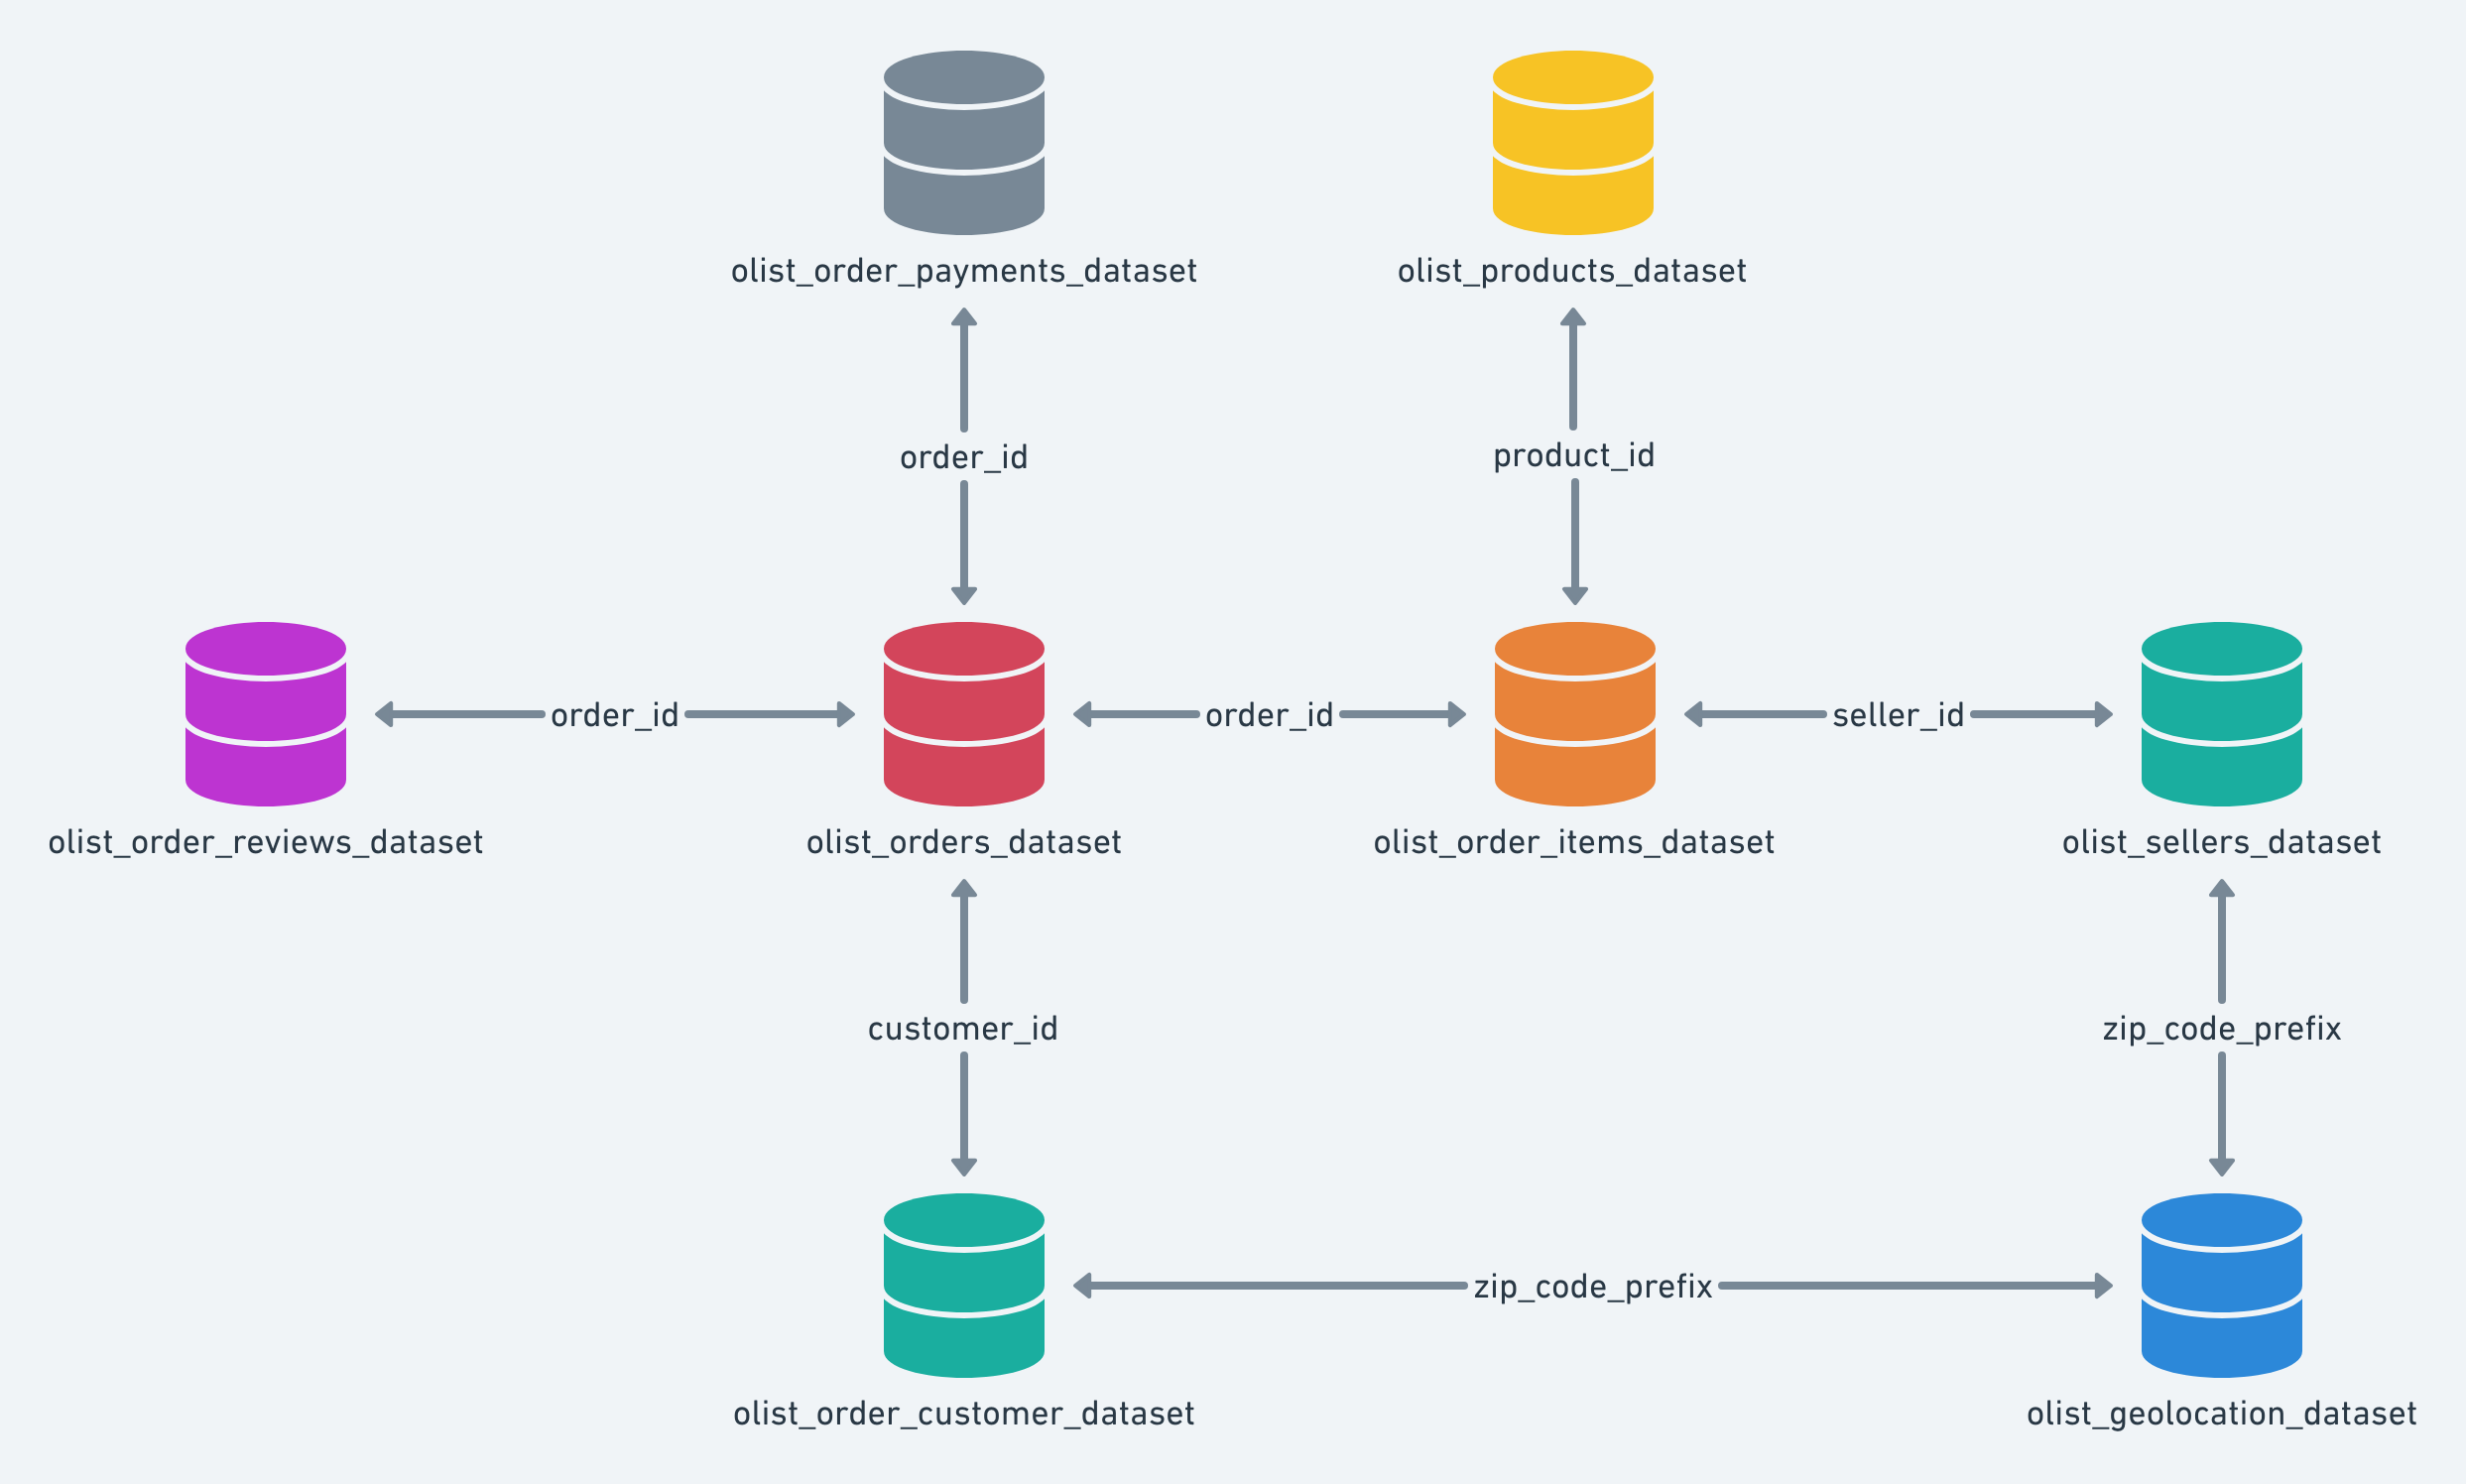

#### customers

In [4]:
print(customers.shape)
print(customers.info())
print(customers.nunique())

# customer_id는 매 주문건마다 새로 생성되는 아이디이다. -> 고객 고유 번호가 아님
# customer_id = 고객번호(주문 건마다 생성되는 고객번호)
# customer_unique_id = 고객 고유 번호(식별자)

# customer_unique_id        customer_id      order_id
# a                           1                 A
# a                           2                 B
# b                           3                 Z


(99441, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64


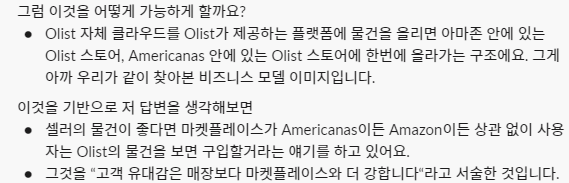

<Axes: xlabel='customer_unique_id'>

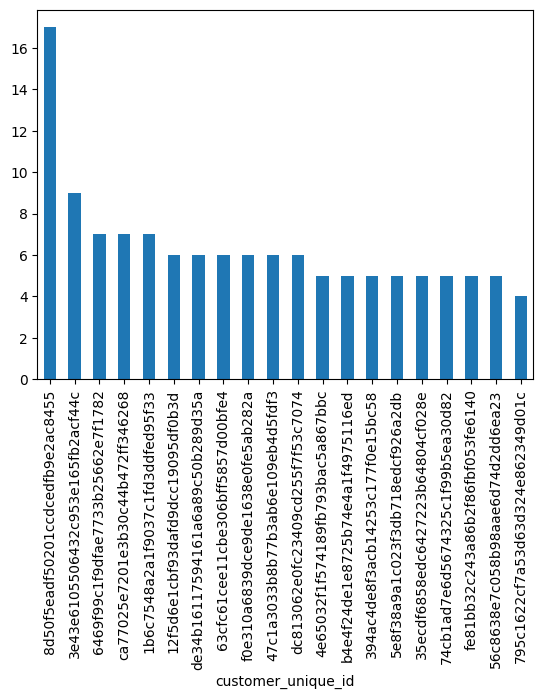

In [5]:
cus_pur=customers.groupby('customer_unique_id')['customer_id'].count().sort_values(ascending=False).head(20)
cus_pur.plot(kind='bar')

# 중복 구매 고객의 경우 99441 - 96096 = 3345명 밖에 없다. 일반적인 중복 구매와는 일치하지 않는다.
# ㄴ 해당 이유는 oliststore가 여러 마켓 플레이스(amazone, americans)에 입점하기 때문에,

# 여기서의 시사점은 이 데이터 분석을 할 때 '구매 고객'의 구매 frequency는 좀 다른 시각으로 봐야한다는 점이다.
# RFM을 한다고 해도 F의 경우 끔찍한 값이 나올 것이다. -> 해당 데이터로 분석한 사람들은 다 일반 구매 고객 관점이던데..

# 중복 구매를 많이 한 '일반 구매 고객'의 구매 횟수를 추출한 결과,
# 최대 17개 중복 구매를 한 것으로 보인다.

In [6]:
temp=pd.merge(customers,orders,on='customer_id',how='left')
temp.groupby('customer_unique_id')[['order_id','customer_id']].count().sort_values(by='order_id',ascending=False).head(10)
# customer_id는 order_id, 즉 주문이 생성될 때마다 생성되는 id임을 확인 완료
# why?: 인구 통계학적 정보가 담긴 customer table과 join하기 위해 만든 것으로 추정.

,order_id,customer_id
customer_unique_id,,
8d50f5eadf50201ccdcedfb9e2ac8455,17,17
3e43e6105506432c953e165fb2acf44c,9,9
6469f99c1f9dfae7733b25662e7f1782,7,7
ca77025e7201e3b30c44b472ff346268,7,7
1b6c7548a2a1f9037c1fd3ddfed95f33,7,7
12f5d6e1cbf93dafd9dcc19095df0b3d,6,6
de34b16117594161a6a89c50b289d35a,6,6
63cfc61cee11cbe306bff5857d00bfe4,6,6
f0e310a6839dce9de1638e0fe5ab282a,6,6


<Axes: xlabel='customer_city'>

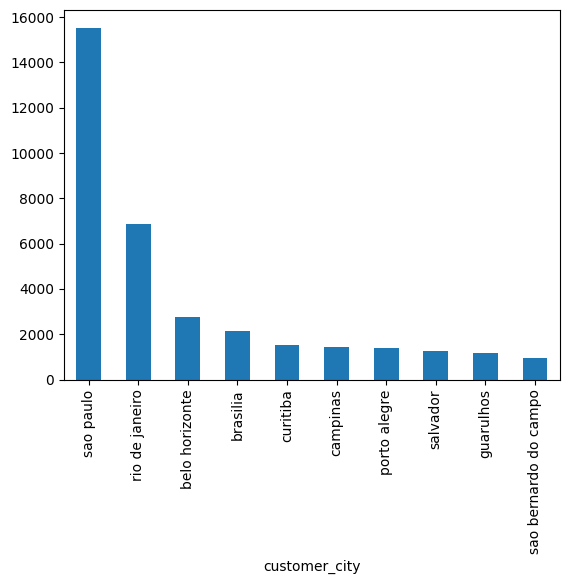

In [7]:
# 일반 구매 고객이 가장 많이 거주하는 top 10 지역
customers.customer_city.value_counts().head(10).plot(kind='bar')

#### sellers

In [8]:
print(sellers.shape)
print(sellers.nunique())
print(sellers.info())

# 본 프로젝트의 "핵심 고객" -> seller
# 총 3095명의 고유 고객이 olist와 계약하고 olist store에 입점하고 있다.
# seller별 매출, 관리 제품 수, 평균 리뷰, 배송 시간, order_status(배송, 취소) 건수, 지역 등이 이들을 세분화하는 기준이 될 것
# public 데이터의 seller들을 일차적으로 살펴보고(2년치 데이터),
# marketing funnel 데이터(1년치 데이터)에 속한 seller들의 위 지표들도 확인해보기
# 두 큼지막한 데이터셋을 활용할 때의 문제점은 날짜의 불일치인데,
# 본격적인 마케팅 시작 전/후로 가정을 해서 살펴볼 수도 있을 것이다. (멘토님 조언)

(3095, 4)
seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None


#### orders

merged_data

In [9]:
print(orders.shape)
orders.nunique()
# customer_id, order_id 간 중복 없음

(99441, 8)


,0
order_id,99441
customer_id,99441
order_status,8
order_purchase_timestamp,98875
order_approved_at,90733
order_delivered_carrier_date,81018
order_delivered_customer_date,95664
order_estimated_delivery_date,459


In [10]:
orders['order_status'].value_counts()
# 주문 상태는 총 8가지가 있다.
# deliverd-> 대부분 배송완료됨
# shipped -> 운송 중
# canceled -> 취소됨
# unavailable -> 사용불가(?) - 확인필요
# invoiced -> 청구됨
# approved -> 승인됨
# processing -> 처리됨

,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


In [11]:
date=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
orders.groupby('order_status')[date].count().reset_index()

# delivered: 배송 완전히 이루어짐 -> 모든 타임 스탬프 찍혀 있음 - sure thing
# approved의 경우 승인되고 아직 배송날짜 등 기입 안됨 -sure thing
# order_delivered_carrier_date: 운송사에 인계된 날짜
# canceled의 경우 주문 구매 및 승인은 되었지만 최종 배송이 없음 -> 취소
# invoiced: 청구되고 아직 배송 안정해짐
# processing: 과정에 있음, 배송 안정해짐
# shipped: 운송 업체에 인계되어 order_delivered_carrier_date가 있음, 아직 최종 배송날짜 정확히 안정해짐
# unavailable: 배송관련 정보 없음, 즉 배송 업체에 인계되기 전. 배송 중 물건 소실 or 재고 부족 처리?



,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,approved,2,2,0,0,2
1,canceled,625,484,75,6,625
2,created,5,0,0,0,5
3,delivered,96478,96464,96476,96470,96478
4,invoiced,314,314,0,0,314
5,processing,301,301,0,0,301
6,shipped,1107,1107,1107,0,1107
7,unavailable,609,609,0,0,609


#### order_items


In [12]:
print(order_items.shape)
order_items.nunique()

(112650, 7)


,0
order_id,98666
order_item_id,21
product_id,32951
seller_id,3095
shipping_limit_date,93318
price,5968
freight_value,6999


In [13]:
order_items['order_id'].value_counts().head()
# 주문 아이디가 중복되는 경우 있음

,count
order_id,
8272b63d03f5f79c56e9e4120aec44ef,21
1b15974a0141d54e36626dca3fdc731a,20
ab14fdcfbe524636d65ee38360e22ce8,20
9ef13efd6949e4573a18964dd1bbe7f5,15
428a2f660dc84138d969ccd69a0ab6d5,15


In [14]:
order_items.groupby('order_id')[['order_item_id','seller_id','product_id']].count().sort_values('order_item_id',ascending=False).head()
# order_id의 경우 중복될 때, item_id와 seller_id가 같은 갯수로 중복되는 것이 확인됨
# 즉, 고객이 주문을 하고 여러 물건을 담으면 담은 물건의 수만큼 주문 아이디가 생성된다.

,order_item_id,seller_id,product_id
order_id,,,
8272b63d03f5f79c56e9e4120aec44ef,21,21,21
1b15974a0141d54e36626dca3fdc731a,20,20,20
ab14fdcfbe524636d65ee38360e22ce8,20,20,20
9ef13efd6949e4573a18964dd1bbe7f5,15,15,15
428a2f660dc84138d969ccd69a0ab6d5,15,15,15


In [15]:
order_items[order_items['order_id']=='9ef13efd6949e4573a18964dd1bbe7f5'] # 15개 아이템 구매

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
69640,9ef13efd6949e4573a18964dd1bbe7f5,1,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2
69641,9ef13efd6949e4573a18964dd1bbe7f5,2,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2
69642,9ef13efd6949e4573a18964dd1bbe7f5,3,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2
69643,9ef13efd6949e4573a18964dd1bbe7f5,4,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2
69644,9ef13efd6949e4573a18964dd1bbe7f5,5,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2
69645,9ef13efd6949e4573a18964dd1bbe7f5,6,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2
69646,9ef13efd6949e4573a18964dd1bbe7f5,7,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2
69647,9ef13efd6949e4573a18964dd1bbe7f5,8,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2
69648,9ef13efd6949e4573a18964dd1bbe7f5,9,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2
69649,9ef13efd6949e4573a18964dd1bbe7f5,10,37eb69aca8718e843d897aa7b82f462d,0b36063d5818f81ccb94b54adfaebbf5,2017-02-03 21:44:49,51.0,1.2


In [16]:
display(order_payments[order_payments['order_id']=='fa65dad1b0e818e3ccc5cb0e39231352'])
display(order_items[order_items['order_id']=='fa65dad1b0e818e3ccc5cb0e39231352'])
print(392.55+65.44)
print(order_payments[order_payments['order_id']=='fa65dad1b0e818e3ccc5cb0e39231352']['payment_value'].sum())
print('*'*300)
display(order_payments[order_payments['order_id']=='8272b63d03f5f79c56e9e4120aec44ef'])
display(order_items[order_items['order_id']=='8272b63d03f5f79c56e9e4120aec44ef'])
print(20*(1.2+7.89)+7.8+6.57) # 살짝 차이나는 건 할부라서 이자

# order_id가 여러번 나오는 경우는 한번 주문할 때 여러 물건을 담아서이다.
# 이 때 여러 개를 샀음을 구분하기 위해 order_item_id가 부여된다.
# 여러 물건의 총 지불 비용은 결국은 물건 수*(가격 + 운임비)이다.

,order_id,payment_sequential,payment_type,payment_installments,payment_value
4885,fa65dad1b0e818e3ccc5cb0e39231352,27,voucher,1,66.02
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
24879,fa65dad1b0e818e3ccc5cb0e39231352,25,voucher,1,3.68
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
32519,fa65dad1b0e818e3ccc5cb0e39231352,11,voucher,1,4.03


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
110202,fa65dad1b0e818e3ccc5cb0e39231352,1,1aecdb5fa3add74e385f25c6c527a462,06532f10282704ef4c69168b914b77be,2017-04-27 09:10:13,392.55,65.44


457.99
457.99
************************************************************************************************************************************************************************************************************************************************************************************************************


,order_id,payment_sequential,payment_type,payment_installments,payment_value
71010,8272b63d03f5f79c56e9e4120aec44ef,1,credit_card,2,196.11


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


196.17000000000002


#### order_payments

In [17]:
print(order_payments.shape)
order_payments.nunique()
# order_id 중복이 있음 -> 같은 주문 내에서 여러 물건을 샀을 때 지불 방식이 다르다는 점일까? -> check
# 지불 방식은 5개이다.

(103886, 5)


,0
order_id,99440
payment_sequential,29
payment_type,5
payment_installments,24
payment_value,29077


<Axes: xlabel='payment_type'>

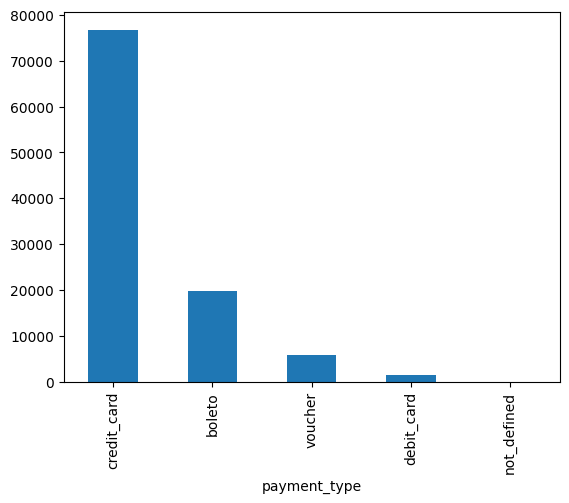

In [18]:
order_payments['payment_type'].value_counts().plot(kind='bar')

In [19]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [20]:
order_payments.groupby('order_id')[['payment_sequential','payment_installments']].count().sort_values('payment_sequential',ascending=False).head(20)

,payment_sequential,payment_installments
order_id,,
fa65dad1b0e818e3ccc5cb0e39231352,29,29
ccf804e764ed5650cd8759557269dc13,26,26
285c2e15bebd4ac83635ccc563dc71f4,22,22
895ab968e7bb0d5659d16cd74cd1650c,21,21
fedcd9f7ccdc8cba3a18defedd1a5547,19,19
ee9ca989fc93ba09a6eddc250ce01742,19,19
4bfcba9e084f46c8e3cb49b0fa6e6159,15,15
21577126c19bf11a0b91592e5844ba78,15,15
3c58bffb70dcf45f12bdf66a3c215905,14,14


In [21]:
order_payments[order_payments['order_id']=='fa65dad1b0e818e3ccc5cb0e39231352']
# payment_sequential: 주문 결제 시퀀스: 같은 주문에 대해 여러 번 결제시 결제의 순서를 나타냄
# 물건을 29개 구매한 사람의 경우 payment_sequential가 중복되지 않고 1~29 숫자가 부여됨, 현 데이터에서는 순서가 정렬되어 있진 않다.

,order_id,payment_sequential,payment_type,payment_installments,payment_value
4885,fa65dad1b0e818e3ccc5cb0e39231352,27,voucher,1,66.02
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
24879,fa65dad1b0e818e3ccc5cb0e39231352,25,voucher,1,3.68
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
32519,fa65dad1b0e818e3ccc5cb0e39231352,11,voucher,1,4.03


In [22]:
order_payments.groupby('payment_sequential')['payment_type'].value_counts()
# 결제 순서가 1보다 큰 경우 대부분 voucher이다. 쿠폰을 여러 장 사용하면 결제 횟수가 느는 듯 하다.

payment_sequential  payment_type
1                   credit_card     76476
                    boleto          19783
                    voucher          1621
                    debit_card       1477
                    not_defined         3
2                   voucher          2669
                    credit_card       318
                    debit_card         51
                    boleto              1
3                   voucher           579
                    debit_card          1
                    credit_card         1
4                   voucher           278
5                   voucher           170
6                   voucher           118
7                   voucher            82
8                   voucher            54
9                   voucher            43
10                  voucher            34
11                  voucher            29
12                  voucher            21
13                  voucher            13
14                  voucher            10
15                  voucher             8
16                  voucher             6
17                  voucher             6
18                  voucher             6
19                  voucher             6
20                  voucher             4
21                  voucher             4
22                  voucher             3
23                  voucher             2
24                  voucher             2
25                  voucher             2
26                  voucher             2
27                  voucher             1
28                  voucher             1
29                  voucher             1
Name: count, dtype: int64

In [23]:
# payment_installments: 할부 횟수 or 할부 개월
order_payments.groupby('payment_installments')['payment_type'].value_counts()
# 일시불의 경우 전체 지불 방식 5개였는데, 이 5개의 지불 방식이 모두 사용됨
# payment_installments가 2이상 인 경우 전부 결제는 신용카드로 이루어졌음

payment_installments  payment_type
0                     credit_card         2
1                     credit_card     25455
                      boleto          19784
                      voucher          5775
                      debit_card       1529
                      not_defined         3
2                     credit_card     12413
3                     credit_card     10461
4                     credit_card      7098
5                     credit_card      5239
6                     credit_card      3920
7                     credit_card      1626
8                     credit_card      4268
9                     credit_card       644
10                    credit_card      5328
11                    credit_card        23
12                    credit_card       133
13                    credit_card        16
14                    credit_card        15
15                    credit_card        74
16                    credit_card         5
17                    credit_card         8
18                    credit_card        27
20                    credit_card        17
21                    credit_card         3
22                    credit_card         1
23                    credit_card         1
24                    credit_card        18
Name: count, dtype: int64

#### order_reviews

In [24]:
print(order_reviews.shape)
print(order_reviews.nunique())
print(order_reviews.info())
# 리뷰 아이디와 주문 아이디가 중복되는 경우 있음
# 리뷰 점수는 5개 척도로 이루어져 있음
# 리뷰 제목과 내용의 결측치가 상당히 많다. 일반 구매 고객 관점에서 볼 때, 별점만 줄수도 있음
# 리뷰를 준 경우, 리뷰 글은 작성하지 않았지만(제목 또는 리뷰 내용), 리뷰 점수는 부여한 것이 확인됨
# 리뷰 내용(포르투칼어) -> 영문 번역 -> Word_cloud & LDA 뽑고 NLP하는 거 재미있을 거 같은데, 결측치가 많아서 고민.
# ㄴ 리뷰 score와 주요 단어의 선형 관계(부정(0)[배송늦음, 부서짐], 긍정(1)[물건 좋음, 저렴, 배송 빠름])를 분석해서 판매자 rate에 사용할 수 있다고 생각을 해봄


(99224, 7)
review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4527
review_comment_message     36159
review_creation_date         636
review_answer_timestamp    98248
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None


<Axes: xlabel='review_score'>

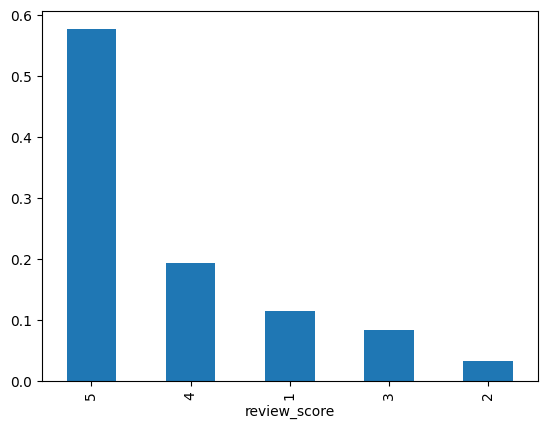

In [25]:
order_reviews['review_score'].value_counts(normalize=True).plot(kind='bar')
# 5점 리뷰가 전체 리뷰의 절반 이상을 차지, 4점 리뷰도 20% 정도
# 의외로 1점의 비율이 2,3점보다 낮게 나왔는데, 향후 판매자 제품 리뷰가 낮은 경우 적용

In [26]:
order_reviews.groupby('review_id')['order_id'].count().sort_values(ascending=False).head(20)
# 리뷰를 단 경우, 최대 3개의 다른 주문에 대해서 리뷰 부여

,order_id
review_id,
ddc52555ca27b0fe67d5255147682d2d,3
2d6ac45f859465b5c185274a1c929637,3
69a1068c3128a14994e3e422e4539e04,3
1fb4ddc969e6bea80e38deec00393a6f,3
832acec9bbf4efe65c3fb6423d8b4ed7,3
39b4603793c1c7f5f36d809b4a218664,3
abbfacb2964f74f6487c9c10ac46daa6,3
44e9f871226d8a130de3fc39dfbdf0c5,3
3415c9f764e478409e8e0660ae816dd2,3


In [27]:
order_reviews[order_reviews['review_id']=='ddc52555ca27b0fe67d5255147682d2d']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
7263,ddc52555ca27b0fe67d5255147682d2d,afed4265a8b956d840bc032e54dfccd1,4,NaN,NaN,2017-08-11 00:00:00,2017-08-12 14:35:03
10112,ddc52555ca27b0fe67d5255147682d2d,3c1098cb17277b62cfc709c7a9b500f5,4,NaN,NaN,2017-08-11 00:00:00,2017-08-12 14:35:03
45434,ddc52555ca27b0fe67d5255147682d2d,d6dde74bdeb424af6b660214881b4845,4,NaN,NaN,2017-08-11 00:00:00,2017-08-12 14:35:03


#### products

In [28]:
print(products.shape)
print(products.nunique())
print(products.info())

# 제품 카테고리의 경우 73개의 대범주 카테고리가 있다.
# 이 73개의 카테고리에서 소범주로 이어지는 제품이 32951개.
# 이외의 제품의 상세 정보가 기입되어 있음(부피, 길이 등)
# 일부 소범주 제품 아이디에 대해, 제품 대범주가 부여되지 않은 경우가 있음: 32951-32341= 610개
# 제품 대범주가 없는 경우, 일부 상세정보가 같은 부여되지 않은 수와 일치하는 수만큼 정보 없음

(32951, 9)
product_id                    32951
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm         

In [29]:
# 제품 대범주 별 소범주 제품 개수
products.groupby('product_category_name')['product_id'].count().sort_values(ascending=False).head(20)
# 포르투칼어로 되어 있어, 제품 영문 번역도 진행 필요

,product_id
product_category_name,
cama_mesa_banho,3029
esporte_lazer,2867
moveis_decoracao,2657
beleza_saude,2444
utilidades_domesticas,2335
automotivo,1900
informatica_acessorios,1639
brinquedos,1411
relogios_presentes,1329


In [30]:
products_trans=products.merge(translation,on='product_category_name',how='left')
products_trans.drop(columns='product_category_name',inplace=True)
products_trans.insert(1,'product_category_name',products_trans['product_category_name_english'])
products_trans.drop(columns='product_category_name_english',inplace=True)
products_trans.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


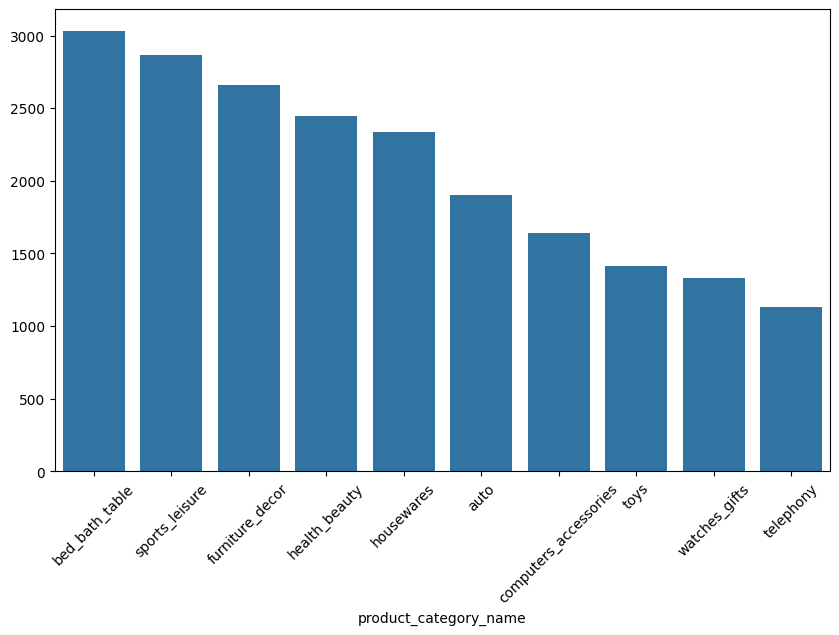

In [31]:
top_10_products=products_trans.groupby('product_category_name')['product_id'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_products.index,y=top_10_products.values)
plt.xticks(rotation=45)
plt.show()
# 판매량, 판매액과 별개로 가장 많이 취급하는 상품군의 top 10 수

## Process 2: 데이터 병합 & 현황파악
- 목적: 전체 2년치 데이터에 대한 여러 지표를 먼저 파악 후 이후 다시 판매자 관점에서 데이터 보기

**셀러등급제 목적, 필요성, 전략** → 기술 (현재상태에서 적합할 것인가)

- EDA: 셀러 상태

### 2.1 데이터 병합

In [32]:
merged_data=pd.merge(customers,orders,on='customer_id',how='left')
merged_data=merged_data.merge(order_payments,on='order_id',how='left')
merged_data=merged_data.merge(order_items,on='order_id',how='left')
merged_data=merged_data.merge(order_reviews,on='order_id',how='left')
merged_data=merged_data.merge(products_trans,on='product_id',how='left')
merged_data=merged_data.merge(sellers,on='seller_id',how='left')

In [33]:
# 날짜형으로 바꿔주기
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for column in date_columns:
    merged_data[column] = pd.to_datetime(merged_data[column], errors='coerce')



In [34]:
merged_data.info()
merged_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    119143 non-null  object        
 1   customer_unique_id             119143 non-null  object        
 2   customer_zip_code_prefix       119143 non-null  int64         
 3   customer_city                  119143 non-null  object        
 4   customer_state                 119143 non-null  object        
 5   order_id                       119143 non-null  object        
 6   order_status                   119143 non-null  object        
 7   order_purchase_timestamp       119143 non-null  datetime64[ns]
 8   order_approved_at              118966 non-null  datetime64[ns]
 9   order_delivered_carrier_date   117057 non-null  datetime64[ns]
 10  order_delivered_customer_date  115722 non-null  datetime64[ns]
 11  

,0
customer_id,0
customer_unique_id,0
customer_zip_code_prefix,0
customer_city,0
customer_state,0
order_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,177
order_delivered_carrier_date,2086


#### 병합 후 결측이 발생한 원인 분석

In [35]:
# 1. 배송 관련 날짜의 결측

print('주문 도착 날짜가 없는 경우:')
print(merged_data[merged_data['order_delivered_customer_date'].isnull()].order_status.value_counts(normalize=True))
print('-' *100)
print('주문 승인 날짜가 없는 경우:')
print(merged_data[merged_data['order_approved_at'].isnull()].order_status.value_counts(normalize=True))
print('-' *100)
print('주문 배송 날짜가 없는 경우:')
print(merged_data[merged_data['order_delivered_carrier_date'].isnull()].order_status.value_counts(normalize=True))

# 앞서 살펴본 대로, 1) 주문 승인되었으나 아직 배송날짜가 결정되지 않았을 때, 2) 주문 이슈가 발생되었을 때 날짜가 아직 안 정해진다.

주문 도착 날짜가 없는 경우:
order_status
shipped        0.367144
canceled       0.217188
unavailable    0.190588
invoiced       0.110494
processing     0.109909
delivered      0.002338
created        0.001462
approved       0.000877
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------
주문 승인 날짜가 없는 경우:
order_status
canceled     0.887006
delivered    0.084746
created      0.028249
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------
주문 배송 날짜가 없는 경우:
order_status
canceled       0.321189
unavailable    0.312560
invoiced       0.181208
processing     0.180249
created        0.002397
approved       0.001438
delivered      0.000959
Name: proportion, dtype: float64


In [36]:
# 2. 리뷰 관련 정보의 결측
print('리뷰가 없는 경우:')
print(merged_data[merged_data['review_score'].isnull()].order_status.value_counts())
print('-' *100)
print('리뷰가 있는 경우:')
print(merged_data[merged_data['review_score'].notnull()].order_status.value_counts())
print('-' *100)
# 모든 주문이 리뷰가 달렸는가?
pd.merge(orders,order_reviews,on='order_id',how='left').review_score.isnull().sum()

# 리뷰의 경우 물건을 주문했지만, 단순히 리뷰를 안 단 경우도 있다.

리뷰가 없는 경우:
order_status
delivered      861
shipped         88
canceled        20
unavailable     14
invoiced         6
processing       6
created          2
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
리뷰가 있는 경우:
order_status
delivered      114862
shipped          1168
canceled          730
unavailable       638
invoiced          372
processing        370
approved            3
created             3
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


768

In [37]:
# 3. 결제 관련 정보의 결측

print('결제 정보가 없는 경우:')
print(merged_data[merged_data['seller_id'].isnull()].order_status.value_counts())
# 마찬가지로 주문 상태가 불가이거나 취소되었을 때 seller_id가 반영 안된 경우가 있다.

print('-' *100)
print('결제 정보가 있는 경우:')
print(merged_data[merged_data['seller_id'].notnull()].order_status.value_counts())
print('-' *100)

print('seller_id는 있으나 주문 불가나 취소가 있는 경우:')
print(merged_data[(merged_data['seller_id'].notnull()) & (merged_data['order_status'].isin(['canceled','unavailable']))].order_status.value_counts())

#

결제 정보가 없는 경우:
order_status
unavailable    645
canceled       180
created          5
invoiced         2
shipped          1
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
결제 정보가 있는 경우:
order_status
delivered      115723
shipped          1255
canceled          570
invoiced          376
processing        376
unavailable         7
approved            3
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
seller_id는 있으나 주문 불가나 취소가 있는 경우:
order_status
canceled       570
unavailable      7
Name: count, dtype: int64


In [38]:
# 4. 제품 관련 정보의 결측

# 제품 대범주 이름이 없다면, 제품의 상세정보도 없다. 2542개
print('product_category가 없는 경우:')
print(merged_data[merged_data['product_category_name'].isnull()].order_status.value_counts(normalize=True))
print('-' *100)
# 제품 대범주는 있지만, 제품 소범주 product_id는 있는 경우
print('product_category가 있는 경우:')
print(merged_data[merged_data['product_category_name'].notnull()].order_status.value_counts(normalize=True))
print('-' *100)
print('product_category가 없으나 product_id는 있는 경우:')
filtered_data = merged_data[(merged_data['product_id'].notnull()) & (merged_data['product_category_name'].isnull())]
print(filtered_data.order_status.value_counts(normalize=True))
print('-' *100)
print('product_category가 없고 product_id도 없는 경우:')
print(merged_data[(merged_data['product_id'].isnull()) & (merged_data['product_category_name'].isnull())].order_status.value_counts(normalize=True))

# product_category가 없다면, 취소와 주문 불가의 32% 정도 차지한다. -> 취소 및 주문 불가 시 제품 범주가 할당안되는 것으로 보임
# product_category가 없지만 product_id가 있는 경우 95%는 배송이 완료된 경우이다.

product_category가 없는 경우:
order_status
delivered      0.647059
unavailable    0.251266
canceled       0.076743
shipped        0.012076
processing     0.005454
invoiced       0.005454
created        0.001948
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------
product_category가 있는 경우:
order_status
delivered      0.978435
shipped        0.010508
canceled       0.004744
invoiced       0.003122
processing     0.003105
unavailable    0.000060
approved       0.000026
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------
product_category가 없으나 product_id는 있는 경우:
order_status
delivered     0.957901
shipped       0.017301
canceled      0.009804
processing    0.008074
invoiced      0.006920
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------
product_category가

In [39]:
# 그래서 결측을 제거할 것인가?

# 일단 보류. 일반 구매 고객 입장에서 볼 때 주문 불가, 취소 등 데이터는 필요없겠지만,
# 핵심 고객인 판매자 입장에서 볼 때, 주문 불가와 취소를 많이 기록한 판매자의 여러 지표를 확인해야함

# 제품 대범주의 경우 주문에 문제가 생겨 반영이 안된 경우도 있지만, 제품 소범주 product_id는 존재하는 경우가 있다.
# 또한 product_id가 존재할 때 주문 상태는 95% 정도 배송이 완료되었기 때문에,
# 시스템 상 문제로 product_id가 있어도 product_category가 없을 수 있음

In [40]:
## 진행 중 문제 발생:

# 데이터를 전부 병합하는 시도 취소 -> 집계할 때 값이 뻥튀기 되는 현상 발생
# 구하고 싶은 지표 있을 때마다 join하는 방식이 좋아보인다.

#### 3가지 방식의 병합 이후 매출 비교
- merged_data(전체 left join)
- df_olist(전체 inner join)
- merged_df: 개 핵심 테이블만 사용해서 매출

In [41]:

date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for column in date_columns:
    merged_data[column] = pd.to_datetime(merged_data[column], errors='coerce')


valid_orders_df = merged_data[(merged_data['order_status'] != 'canceled') & (merged_data['order_status'] != 'unavailable')]

valid_orders_df['order_purchase_timestamp'] = pd.to_datetime(valid_orders_df['order_purchase_timestamp'])

valid_orders_df['Year'] = valid_orders_df['order_purchase_timestamp'].dt.year
valid_orders_df['Quarter'] = valid_orders_df['order_purchase_timestamp'].dt.quarter
quarterly_revenue = valid_orders_df.groupby(['Year', 'Quarter'])['payment_value'].sum().reset_index()
quarterly_revenue['Total Revenue'] = quarterly_revenue['payment_value'].round(2)
quarterly_revenue.drop(columns='payment_value', inplace=True)
print("Quarterly Revenue")
print(quarterly_revenue)

valid_orders_df['Month'] = valid_orders_df['order_purchase_timestamp'].dt.month
monthly_revenue = valid_orders_df.groupby(['Year', 'Month'])['payment_value'].sum().reset_index()
monthly_revenue['Total Revenue'] = monthly_revenue['payment_value'].round(2)
monthly_revenue.drop(columns='payment_value', inplace=True)
print("Monthly Revenue")
print(monthly_revenue)


yearly_revenue = valid_orders_df.groupby('Year')['payment_value'].sum().reset_index()
yearly_revenue['Total Revenue'] = yearly_revenue['payment_value'].round(2)
yearly_revenue.drop(columns='payment_value', inplace=True)
print("Yearly Revenue")
print(yearly_revenue)

# 모든 테이블을 병합했을 때의 연도별 매출과 두 개 orders & orders_payment 병합했을 때 차이가 너무 크다.
# 매출은 orders & orders_payment 확인하는 것이 정답이다.

Quarterly Revenue
   Year  Quarter  Total Revenue
0  2016        3         272.46
1  2016        4       68354.17
2  2017        1     1056379.61
3  2017        2     1816218.84
4  2017        3     2625090.36
5  2017        4     3657938.75
6  2018        1     4205516.14
7  2018        2     4289402.78
8  2018        3     2545635.37
Monthly Revenue
    Year  Month  Total Revenue
0   2016      9         272.46
1   2016     10       68334.55
2   2016     12          19.62
3   2017      1      189324.99
4   2017      2      343562.06
5   2017      3      523492.56
6   2017      4      489920.59
7   2017      5      723969.75
8   2017      6      602328.50
9   2017      7      734518.62
10  2017      8      870997.00
11  2017      9     1019574.74
12  2017     10     1030838.82
13  2017     11     1583147.44
14  2017     12     1043952.49
15  2018      1     1412401.88
16  2018      2     1313863.60
17  2018      3     1479250.66
18  2018      4     1494527.03
19  2018      5     149908

In [42]:
merged_data['order_id'].value_counts().head()

,count
order_id,
895ab968e7bb0d5659d16cd74cd1650c,63
fedcd9f7ccdc8cba3a18defedd1a5547,38
fa65dad1b0e818e3ccc5cb0e39231352,29
ccf804e764ed5650cd8759557269dc13,26
a3725dfe487d359b5be08cac48b64ec5,24


In [43]:
df_olist = pd.merge(customers, orders, on= 'customer_id' , how= 'inner' )
df_olist = df_olist.merge(order_payments, on= 'order_id' , how= "inner" )
df_olist = df_olist.merge(order_items, on= 'order_id' , how= "inner" )
df_olist = df_olist.merge(order_reviews, on= 'order_id' , how= "inner" )
df_olist = df_olist.merge(products_trans, on= 'product_id' , how= "inner" )
# df_olist.drop_duplicates(subset={'order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date'},keep='first',inplace=True)
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    117329 non-null  object 
 1   customer_unique_id             117329 non-null  object 
 2   customer_zip_code_prefix       117329 non-null  int64  
 3   customer_city                  117329 non-null  object 
 4   customer_state                 117329 non-null  object 
 5   order_id                       117329 non-null  object 
 6   order_status                   117329 non-null  object 
 7   order_purchase_timestamp       117329 non-null  object 
 8   order_approved_at              117314 non-null  object 
 9   order_delivered_carrier_date   116094 non-null  object 
 10  order_delivered_customer_date  114858 non-null  object 
 11  order_estimated_delivery_date  117329 non-null  object 
 12  payment_sequential            

In [44]:

date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for column in date_columns:
    df_olist[column] = pd.to_datetime(df_olist[column], errors='coerce')


# 주문 상태가 'canceled' 또는 'unavailable'이 아닌 주문만 필터링
valid_orders_df = df_olist[(df_olist['order_status'] != 'canceled') & (df_olist['order_status'] != 'unavailable')]


valid_orders_df['order_purchase_timestamp'] = pd.to_datetime(valid_orders_df['order_purchase_timestamp'])


valid_orders_df['Year'] = valid_orders_df['order_purchase_timestamp'].dt.year
valid_orders_df['Quarter'] = valid_orders_df['order_purchase_timestamp'].dt.quarter
quarterly_revenue = valid_orders_df.groupby(['Year', 'Quarter'])['payment_value'].sum().reset_index()
quarterly_revenue['Total Revenue'] = quarterly_revenue['payment_value'].round(2)
quarterly_revenue.drop(columns='payment_value', inplace=True)
print("Quarterly Revenue")
print(quarterly_revenue)

valid_orders_df['Month'] = valid_orders_df['order_purchase_timestamp'].dt.month
monthly_revenue = valid_orders_df.groupby(['Year', 'Month'])['payment_value'].sum().reset_index()
monthly_revenue['Total Revenue'] = monthly_revenue['payment_value'].round(2)
monthly_revenue.drop(columns='payment_value', inplace=True)
print("Monthly Revenue")
print(monthly_revenue)

yearly_revenue = valid_orders_df.groupby('Year')['payment_value'].sum().reset_index()
yearly_revenue['Total Revenue'] = yearly_revenue['payment_value'].round(2)
yearly_revenue.drop(columns='payment_value', inplace=True)
print("Yearly Revenue")
print(yearly_revenue)

# 모든 테이블을 병합했을 때의 연도별 매출과 두 개 orders & orders_payment 병합했을 때 차이가 너무 크다.
# 매출은 orders & orders_payment 확인하는 것이 정답이다.

Quarterly Revenue
   Year  Quarter  Total Revenue
0  2016        3         272.46
1  2016        4       66645.49
2  2017        1     1044842.67
3  2017        2     1801319.59
4  2017        3     2561146.00
5  2017        4     3615036.74
6  2018        1     4161464.83
7  2018        2     4262248.96
8  2018        3     2524738.34
Monthly Revenue
    Year  Month  Total Revenue
0   2016      9         272.46
1   2016     10       66625.87
2   2016     12          19.62
3   2017      1      187862.21
4   2017      2      342145.88
5   2017      3      514834.58
6   2017      4      484353.73
7   2017      5      717753.46
8   2017      6      599212.40
9   2017      7      728051.11
10  2017      8      818740.00
11  2017      9     1014354.89
12  2017     10     1019022.95
13  2017     11     1567265.03
14  2017     12     1028748.76
15  2018      1     1397879.67
16  2018      2     1297770.00
17  2018      3     1465815.16
18  2018      4     1483148.56
19  2018      5     148851

In [45]:
# 판매자 별 주문 건수
df_olist['order_id'].value_counts().head()

,count
order_id,
895ab968e7bb0d5659d16cd74cd1650c,63
fedcd9f7ccdc8cba3a18defedd1a5547,38
fa65dad1b0e818e3ccc5cb0e39231352,29
ccf804e764ed5650cd8759557269dc13,26
465c2e1bee4561cb39e0db8c5993aafc,24


In [46]:
p=pd.merge(order_items,products_trans,on='product_id',how='left')
p.groupby('product_category_name')['order_id'].count().sort_values(ascending=False).head()

,order_id
product_category_name,
bed_bath_table,11115
health_beauty,9670
sports_leisure,8641
furniture_decor,8334
computers_accessories,7827


In [47]:
p.isnull().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0
product_category_name,1627
product_name_lenght,1603
product_description_lenght,1603


In [48]:
products_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32328 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [49]:
print((order_items['freight_value']+order_items['price']).sum())

15843553.24


In [50]:
# 2개 테이블만을 join 했을 때의 매출이 정답이다.

valid_orders_df = orders[(orders['order_status'] != 'canceled') & (orders['order_status'] != 'unavailable')]

# 유효한 주문과 결제 데이터 병합
merged_df = pd.merge(valid_orders_df, order_payments, on='order_id')

# 전체 매출 계산
total_revenue = round(merged_df['payment_value'].sum(), 2)
print(f"Total Revenue: {total_revenue}")

# 'order_purchase_timestamp'를 datetime 형식으로 변환
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])

# 연도와 분기별로 그룹화하여 매출 계산
merged_df['Year'] = merged_df['order_purchase_timestamp'].dt.year
merged_df['Quarter'] = merged_df['order_purchase_timestamp'].dt.quarter
quarterly_revenue = merged_df.groupby(['Year', 'Quarter'])['payment_value'].sum().reset_index()
quarterly_revenue['Total Revenue'] = quarterly_revenue['payment_value'].round(2)
quarterly_revenue.drop(columns='payment_value', inplace=True)
print("Quarterly Revenue")
print(quarterly_revenue)

# 연도와 월별로 그룹화하여 매출 계산
merged_df['Month'] = merged_df['order_purchase_timestamp'].dt.month
monthly_revenue = merged_df.groupby(['Year', 'Month'])['payment_value'].sum().reset_index()
monthly_revenue['Total Revenue'] = monthly_revenue['payment_value'].round(2)
monthly_revenue.drop(columns='payment_value', inplace=True)
print("Monthly Revenue")
print(monthly_revenue)

# 연도별 매출 계산
yearly_revenue = merged_df.groupby('Year')['payment_value'].sum().reset_index()
yearly_revenue['Total Revenue'] = yearly_revenue['payment_value'].round(2)
yearly_revenue.drop(columns='payment_value', inplace=True)
print("Yearly Revenue")
print(yearly_revenue)

Total Revenue: 15739137.01
Quarterly Revenue
   Year  Quarter  Total Revenue
0  2016        3         136.23
1  2016        4       51677.15
2  2017        1      846285.10
3  2017        2     1488742.01
4  2017        3     1958125.57
5  2017        4     2799338.97
6  2018        1     3235342.38
7  2018        2     3322546.83
8  2018        3     2036942.77
Monthly Revenue
    Year  Month  Total Revenue
0   2016      9         136.23
1   2016     10       51657.53
2   2016     12          19.62
3   2017      1      137006.76
4   2017      2      283621.94
5   2017      3      425656.40
6   2017      4      405988.38
7   2017      5      582926.16
8   2017      6      499827.47
9   2017      7      578858.58
10  2017      8      662071.77
11  2017      9      717195.22
12  2017     10      764785.28
13  2017     11     1172639.23
14  2017     12      861914.46
15  2018      1     1102639.41
16  2018      2      979966.23
17  2018      3     1152736.74
18  2018      4     1156303.91

In [51]:
merged_df['order_id'].value_counts().head()

,count
order_id,
fa65dad1b0e818e3ccc5cb0e39231352,29
ccf804e764ed5650cd8759557269dc13,26
285c2e15bebd4ac83635ccc563dc71f4,22
895ab968e7bb0d5659d16cd74cd1650c,21
ee9ca989fc93ba09a6eddc250ce01742,19


In [52]:
order_payments['order_id'].value_counts().head()

,count
order_id,
fa65dad1b0e818e3ccc5cb0e39231352,29
ccf804e764ed5650cd8759557269dc13,26
285c2e15bebd4ac83635ccc563dc71f4,22
895ab968e7bb0d5659d16cd74cd1650c,21
fedcd9f7ccdc8cba3a18defedd1a5547,19


In [53]:
order_items['order_id'].value_counts().head()

,count
order_id,
8272b63d03f5f79c56e9e4120aec44ef,21
1b15974a0141d54e36626dca3fdc731a,20
ab14fdcfbe524636d65ee38360e22ce8,20
9ef13efd6949e4573a18964dd1bbe7f5,15
428a2f660dc84138d969ccd69a0ab6d5,15


In [54]:
print(df_olist['payment_value'].sum()) # 1
print(merged_data['payment_value'].sum()) # 2
print(merged_df['payment_value'].sum()) # 3
print((order_items['freight_value']+order_items['price']).sum()) # 4

# 총 주문 금액이 위 2개 모든 데이터 병합의 경우 3,4번 종합 데이터 30%나 더 크게 나오는 문제 발생한다.
# 필요할 때 관련 테이블만 병합하는 것이 좋아보인다.

20187928.7
20579664.009999998
15739137.01
15843553.24


In [55]:
# merged_order_items_df = pd.merge(order_items, orders, on='order_id')
# merged_order_items_df = pd.merge(merged_order_items_df, order_payments, on='order_id')
# filtered_merged_df = merged_order_items_df[~merged_order_items_df['order_status'].isin(['canceled', 'unavailable'])]

# total_freight_value = filtered_merged_df.groupby('seller_id')['freight_value'].sum().reset_index().rename(columns={'freight_value': 'total_freight_value'})
# average_freight_value = filtered_merged_df.groupby('seller_id')['freight_value'].mean().reset_index().rename(columns={'freight_value': 'average_freight_value'})
# median_order_value = filtered_merged_df.groupby('seller_id')['payment_value'].median().reset_index().rename(columns={'payment_value': 'median_order_value'})
# max_order_value = filtered_merged_df.groupby('seller_id')['payment_value'].max().reset_index().rename(columns={'payment_value': 'max_order_value'})
# min_order_value = filtered_merged_df.groupby('seller_id')['payment_value'].min().reset_index().rename(columns={'payment_value': 'min_order_value'})
# total_customers = filtered_merged_df.groupby('seller_id')['customer_id'].nunique().reset_index().rename(columns={'customer_id': 'total_customers'})
# order_value_variance = filtered_merged_df.groupby('seller_id')['payment_value'].var().reset_index().rename(columns={'payment_value': 'order_value_variance'})
# order_value_standard_deviation = filtered_merged_df.groupby('seller_id')['payment_value'].std().reset_index().rename(columns={'payment_value': 'order_value_standard_deviation'})



### 2.2 현황 파악

#### 확인할 내용들

#### 현황 시각화

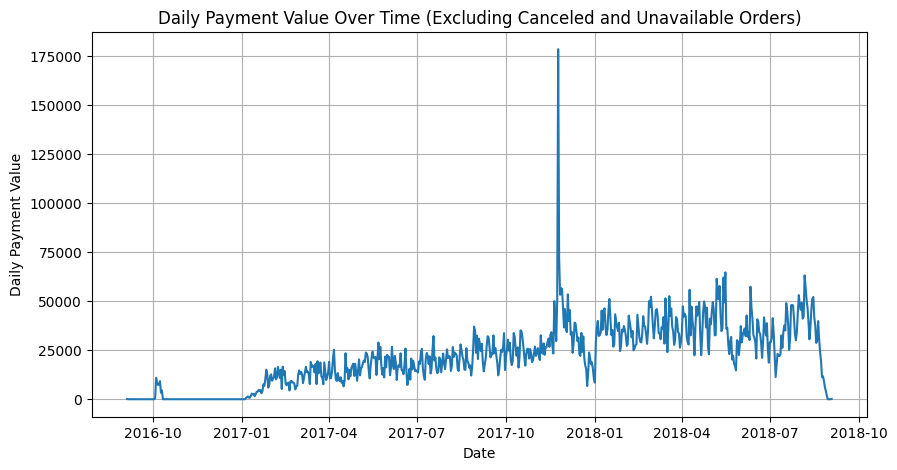

In [56]:
# 1.1 매출 추이 - 일별
# filtered_data = merged_data[~merged_data['order_status'].isin(['canceled', 'unavailable'])]
daily_payment_value = merged_df.set_index('order_purchase_timestamp').resample('D')['payment_value'].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(daily_payment_value['order_purchase_timestamp'], daily_payment_value['payment_value'])
plt.xlabel('Date')
plt.ylabel('Daily Payment Value')
plt.title('Daily Payment Value Over Time (Excluding Canceled and Unavailable Orders)')
plt.grid(True)
plt.show()

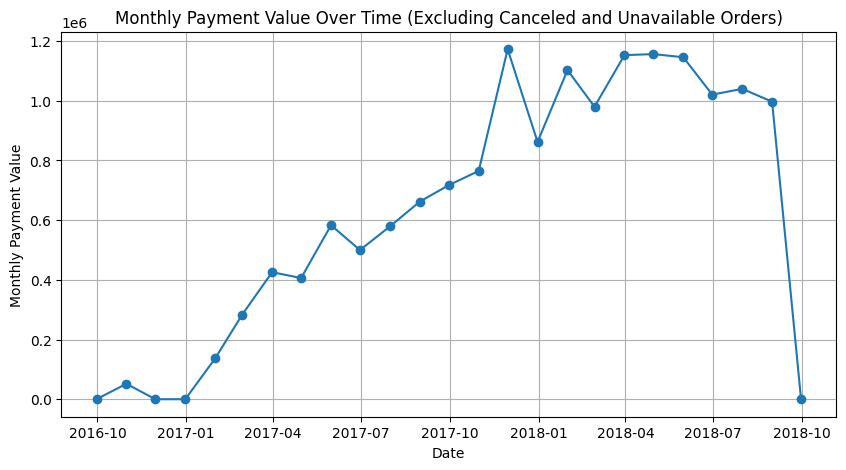

In [57]:
# 1.2 매출 추이 - 월별

monthly_payment_value = merged_df.set_index('order_purchase_timestamp').resample('M')['payment_value'].sum().reset_index()


plt.figure(figsize=(10, 5))
plt.plot(monthly_payment_value['order_purchase_timestamp'], monthly_payment_value['payment_value'], marker='o')

plt.xlabel('Date')
plt.ylabel('Monthly Payment Value')
plt.title('Monthly Payment Value Over Time (Excluding Canceled and Unavailable Orders)')
plt.grid(True)
plt.show()

# 2017년 부터 꾸준히 매출이 성장하고 있다. 2017년 11~12월에 매출이 가장 높게 나타남
# 연말 및 연초에 매출이 낮아졌다가, 다시 회복
# 2018년 9월 부터 2018년 10월에 매출 급감

In [58]:
# merged_df2=merged_df.copy()
# merged_df2['order_purchase_timestamp'] = pd.to_datetime(merged_df2['order_purchase_timestamp'])
# merged_df2['year_month'] = merged_df2['order_purchase_timestamp'].dt.to_period('M')
# merged_df2.groupby('year_month')['payment_value'].sum().reset_index()

In [60]:
orders_df=orders.copy()
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [61]:
for column in date_columns:
    orders_df[column] = pd.to_datetime(orders_df[column], errors='coerce')

In [62]:
date_columns

['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date']

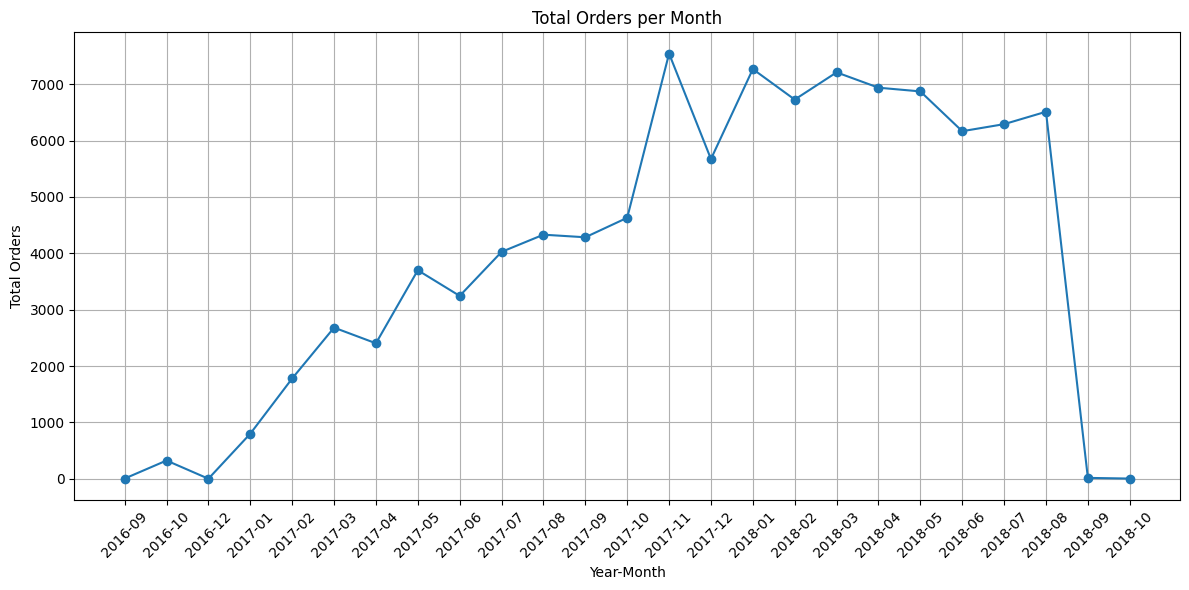

In [63]:
# 월별 주문 건수
orders_df = orders.copy()
date_colums=['order_purchase_timestamp']
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['year_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')

month_order_counts = orders_df.groupby('year_month')['order_id'].count().reset_index()


plt.figure(figsize=(12, 6))
plt.plot(month_order_counts['year_month'].astype(str), month_order_counts['order_id'], marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Total Orders')
plt.title('Total Orders per Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

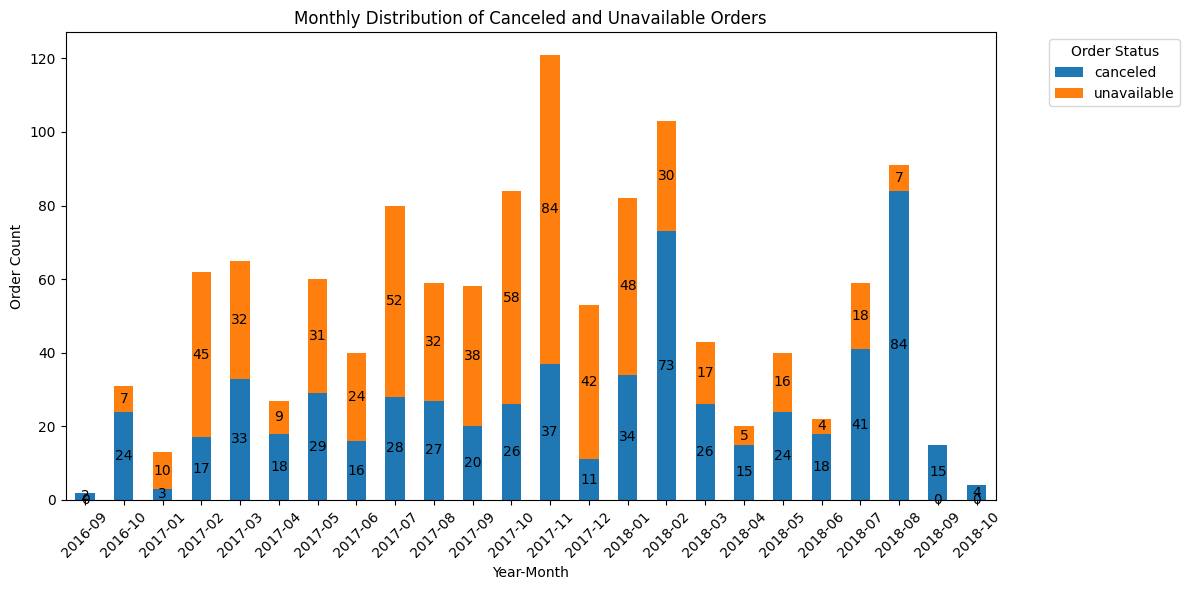

In [64]:
# 취소 또는 주문 불가의 월별 분포

unnormal_status = orders_df['order_status'].isin(['canceled', 'unavailable'])
unnormal_status_counts = orders_df[unnormal_status].groupby(['year_month', 'order_status']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))

unnormal_status_counts.plot(kind='bar', stacked=True, ax=ax)

# 숫자 라벨 추가
for container in ax.containers:
    ax.bar_label(container, label_type='center')

ax.set_xlabel('Year-Month')
ax.set_ylabel('Order Count')
ax.set_title('Monthly Distribution of Canceled and Unavailable Orders')
plt.xticks(rotation=45)
plt.legend(title='Order Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

# 취소 또는 주문 불가가 가장 많이 나오는 월의 경우 2017년 11월으로, 블랙 프라이데이 등 할인행사로 인한 재고 부족으로 인한 주문 불가,
# 주문 수에 비례한 주문 취소가 많이 증가한 것으로 판단됨. 이 때 어떤 제품이 주로 이런 행위 발생시켰는지 판단하기
# 2018년 2월 및 2018년 8월에 주문 취소된 내역이 많다. 어떤 판매자에 의한 것인지, 어떤 제품인지, 리뷰가, 배송 기간이 등 판단

In [65]:
# 3.1 상황별 top 10 카테고리

product_df=pd.merge(products_trans,order_items,on='product_id',how='inner').merge(orders_df,on='order_id',how='inner').merge(order_payments,on='order_id',how='inner')


# canceled, unavailable 제외
product_df_order=product_df[~product_df['order_status'].isin(['canceled', 'unavailable'])]

# 매출이 높은 제품 카테고리 Top 10
top_revenue_categories = product_df_order.groupby('product_category_name')['payment_value'].sum().nlargest(10).reset_index()

# 주문이 많은 제품 카테고리 Top 10
top_order_categories = product_df_order.groupby('product_category_name')['order_id'].count().nlargest(10).reset_index()

# 취소가 많았던 제품 카테고리 Top 10
canceled_orders = product_df[product_df['order_status'] == 'canceled']
top_canceled_categories = canceled_orders.groupby('product_category_name')['order_id'].count().nlargest(10).reset_index()


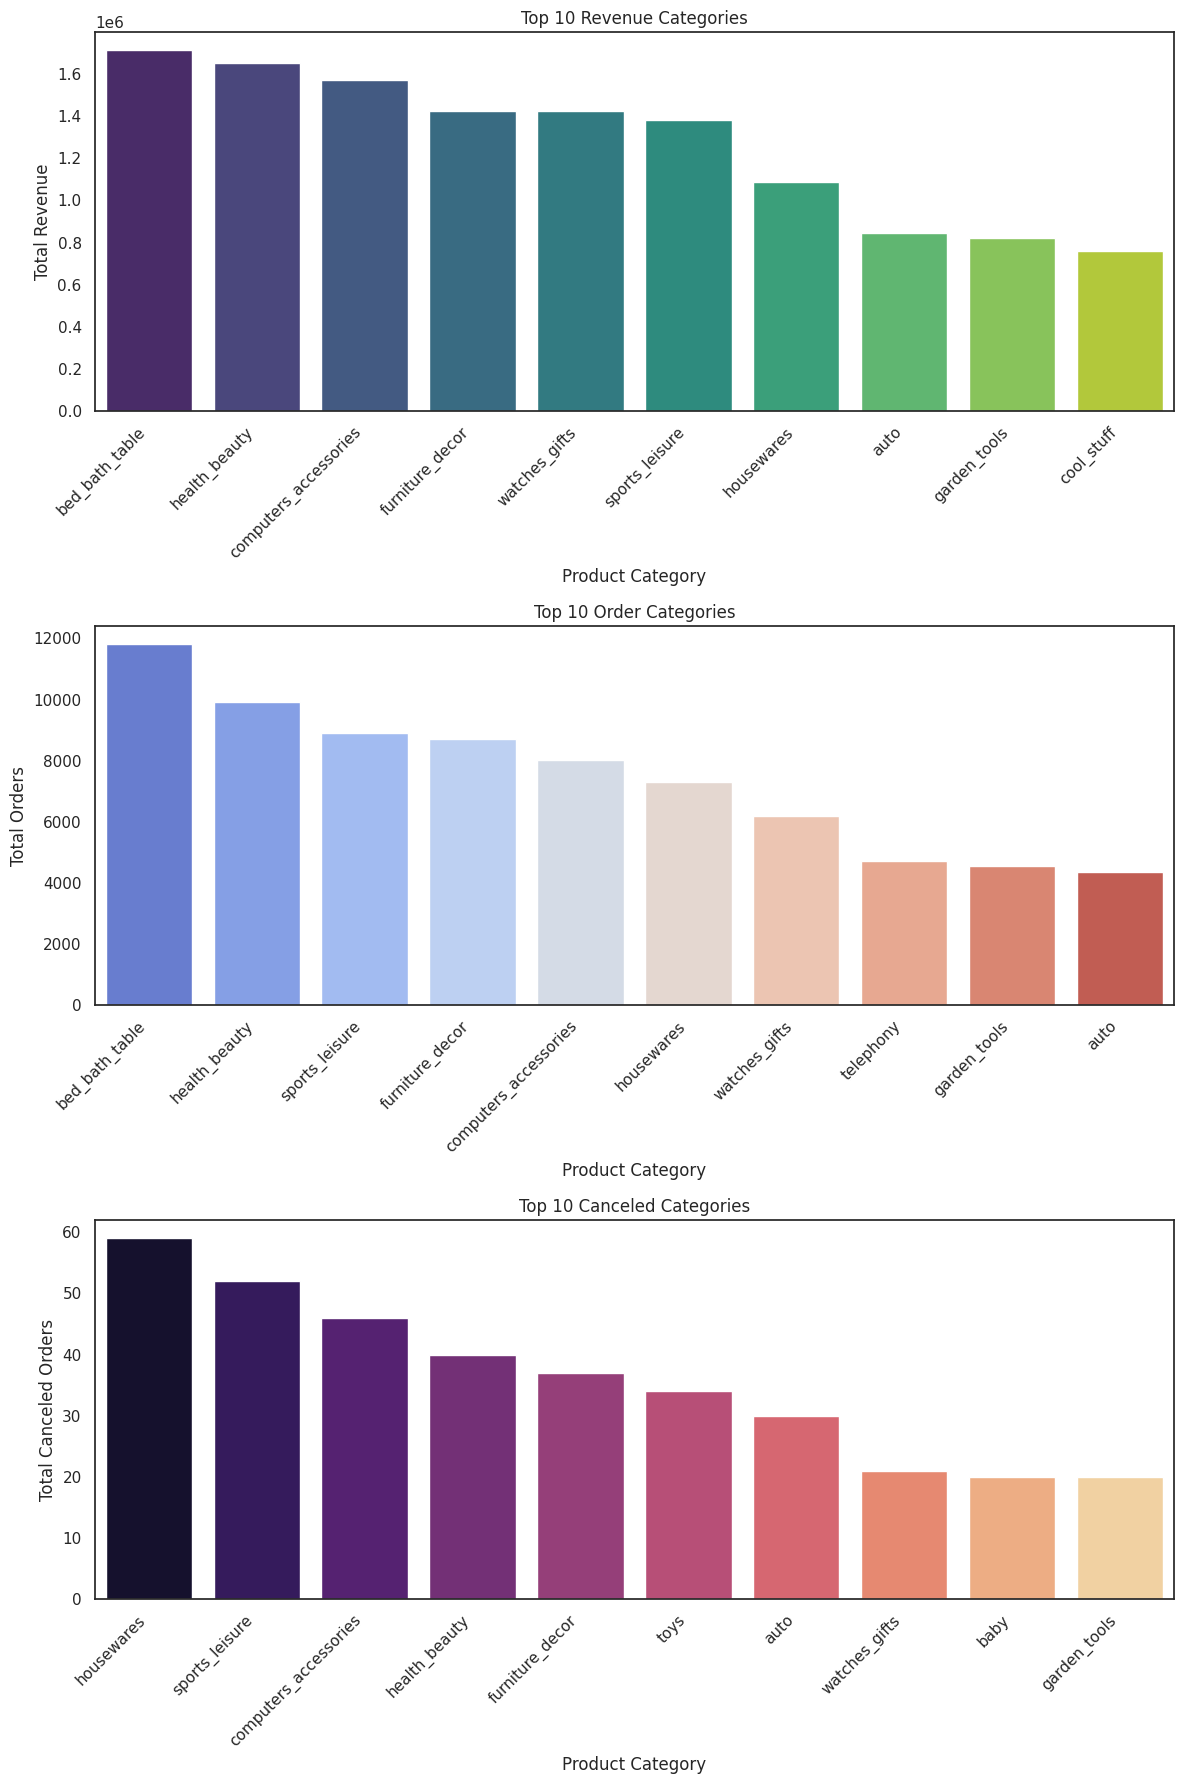

In [66]:

sns.set(style="white")


fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# 매출이 높은 제품 카테고리
sns.barplot(x='product_category_name', y='payment_value', data=top_revenue_categories, palette="viridis", ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
axs[0].grid(False)


sns.barplot(x='product_category_name', y='order_id', data=top_order_categories, palette="coolwarm", ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].grid(False)


sns.barplot(x='product_category_name', y='order_id', data=top_canceled_categories, palette="magma", ax=axs[2])
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')
axs[2].grid(False)


axs[0].set_title('Top 10 Revenue Categories')
axs[1].set_title('Top 10 Order Categories')
axs[2].set_title('Top 10 Canceled Categories')

axs[0].set_xlabel('Product Category')
axs[1].set_xlabel('Product Category')
axs[2].set_xlabel('Product Category')

axs[0].set_ylabel('Total Revenue')
axs[1].set_ylabel('Total Orders')
axs[2].set_ylabel('Total Canceled Orders')

plt.tight_layout()
plt.show()

# bed_bath_table과 heath_beauty 등의 매출액과 판매수량이 높은 것으로 나온다. 해당 제품들의 객단가 역시 확인해볼 수 있다.
# 취소가 많이된 제품의 경우는 house_ware, sports_leisure, computer accessary 등으로 해당 제품의 리뷰와 물건을 파는 판매자, 배송 등 확인

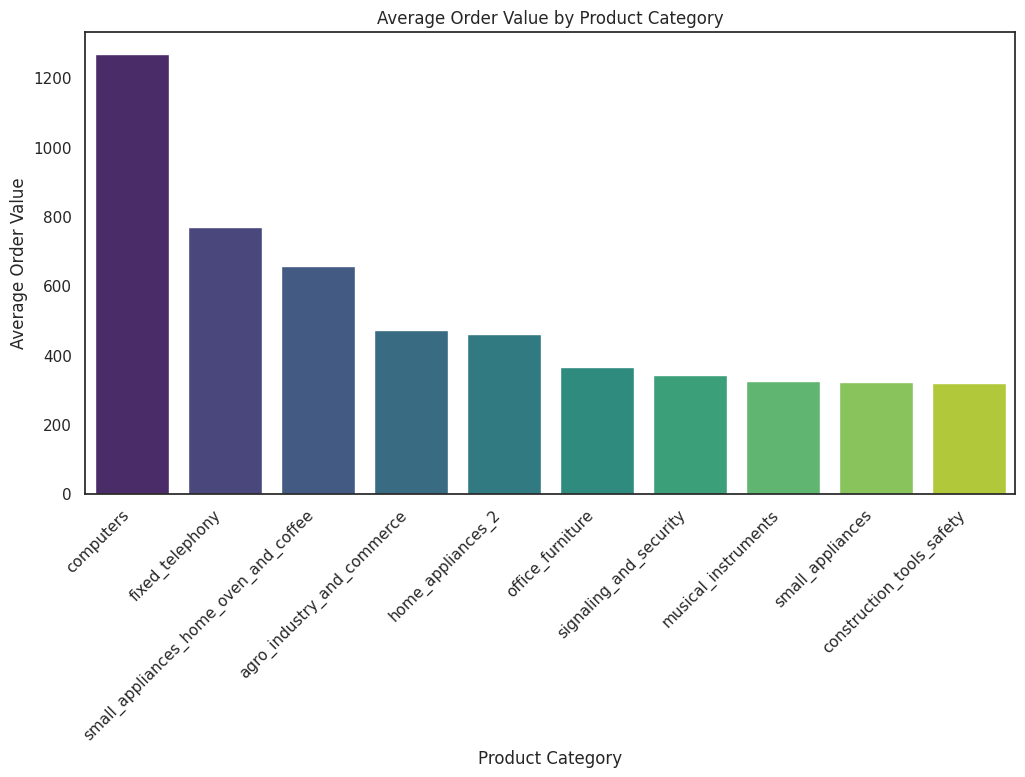

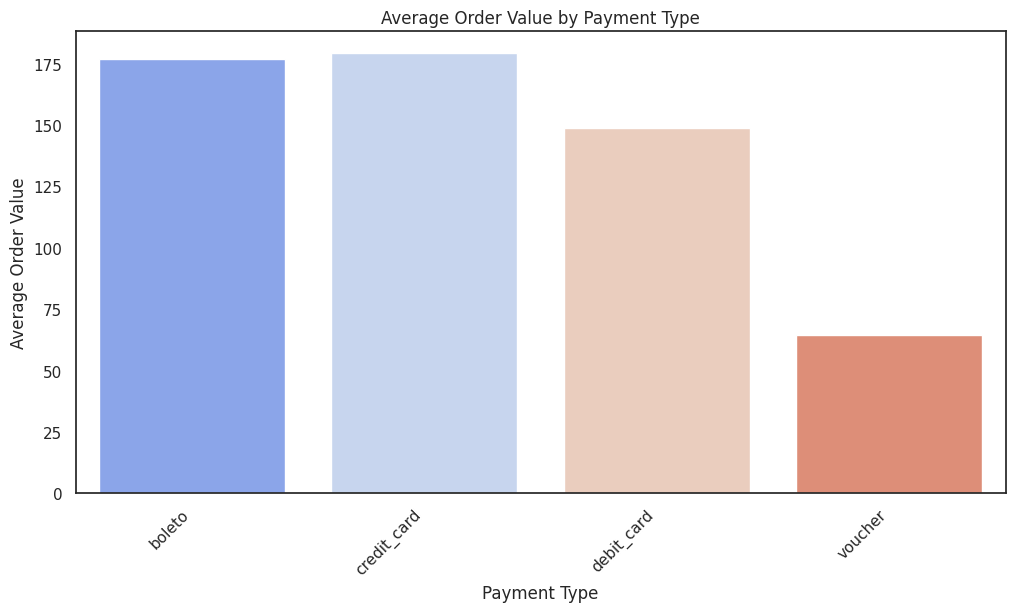

In [67]:
# 3.2

# 제품 카테고리별 평균 주문 가치 계산 top 10
category_aov = product_df_order.groupby('product_category_name')['payment_value'].mean().nlargest(10).reset_index()

payment_aov = product_df_order.groupby('payment_type')['payment_value'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(x='product_category_name', y='payment_value', data=category_aov, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Product Category')
plt.ylabel('Average Order Value')
plt.title('Average Order Value by Product Category')
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(x='payment_type', y='payment_value', data=payment_aov, palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Payment Type')
plt.ylabel('Average Order Value')
plt.title('Average Order Value by Payment Type')
plt.show()



In [68]:
# 1.2 실제 수령과 기대 수령 기간 차이 시각화, x축은 차이, y축은 빈도
# 1.3 월별 지연된 배송 주문 수 시각화


# 1.6 배송을 지연시킨 seller, 평균 배송 시간이 긴 seller 시각화

In [69]:
for column in date_columns:
    orders_df[column] = pd.to_datetime(orders_df[column], errors='coerce')

In [70]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   year_month                     99441 non-null  period[M]     
dtypes: datetime64[ns](5), object(3), period[M](1)
memory usage: 6.8+ MB


In [71]:
# 4 배송 상태 및 배송 시간

# 4.1 실제 수령 - 기대 수령 기간 < 0 지연된 주문, 지연 여부 컬럼, 지연 시간 컬럼 추가
orders_df['delay'] = (orders_df['order_delivered_customer_date'] - orders_df['order_estimated_delivery_date']).dt.days
orders_df['is_delayed'] = orders_df['delay'] > 0

# 지연 여부와 지연 시간 컬럼 추가 확인
orders_df[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'delay', 'is_delayed']].head()


,order_id,order_delivered_customer_date,order_estimated_delivery_date,delay,is_delayed
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,-8.0,False
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,-6.0,False
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,-18.0,False
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,-13.0,False
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,-10.0,False


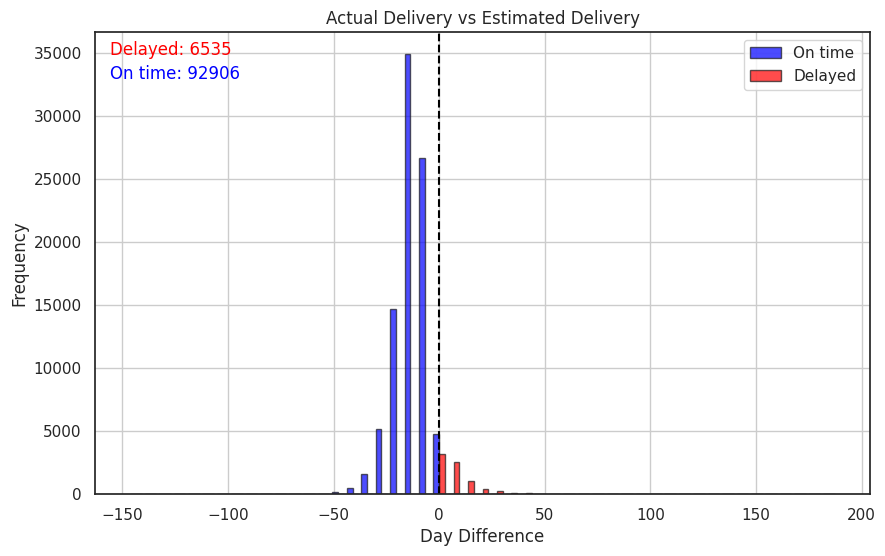

In [72]:


delay = orders_df['delay'].dropna()
bins = np.linspace(delay.min(), delay.max(), 50)

# 지연/미지연 배송 개수 계산
delayed_count = orders_df['is_delayed'].sum()
on_time_count = (~orders_df['is_delayed']).sum()

plt.figure(figsize=(10, 6))
plt.hist([delay[delay < 0], delay[delay >= 0]], bins=bins, color=['blue', 'red'], edgecolor='k', alpha=0.7, label=['On time', 'Delayed'])
plt.axvline(0, color='black', linestyle='--')
plt.title('Actual Delivery vs Estimated Delivery')
plt.xlabel('Day Difference')
plt.ylabel('Frequency')

plt.text(0.02, 0.95, f'Delayed: {delayed_count}', transform=plt.gca().transAxes, color='red', fontsize=12)
plt.text(0.02, 0.90, f'On time: {on_time_count}', transform=plt.gca().transAxes, color='blue', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()


# 배송 성과:

# 대부분의 주문이 제 시간에 배송되었다는 것은 배송 프로세스가 비교적 효율적으로 운영되고 있음을 시사한다.
# 그러나 약 6,535개의 주문이 지연된 것은 일부 지역 또는 특정 기간 동안의 물류 문제일 수 있다.
# 지연 원인 분석 필요:

# 지연된 주문의 원인을 파악하기 위해 추가적인 분석이 필요할 듯. 지연이 특정 지역에서 더 많이 발생하는~

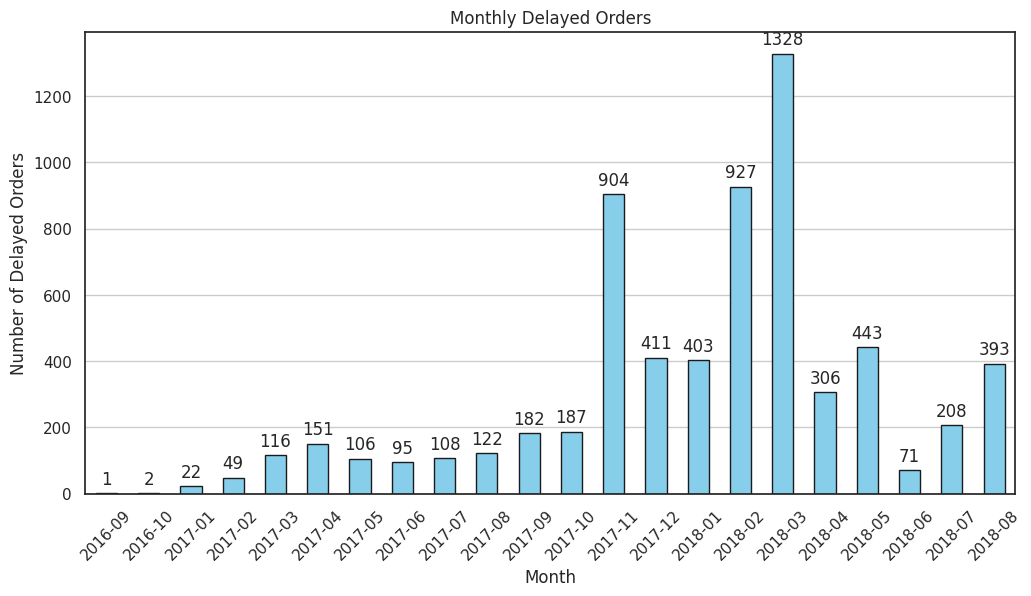

In [73]:
# 월별 지연된 주문 수 시각화

orders_df['order_purchase_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')
monthly_delayed_orders = orders_df[orders_df['is_delayed']].groupby('order_purchase_month').size()

plt.figure(figsize=(12, 6))
ax = monthly_delayed_orders.plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Monthly Delayed Orders')
plt.xlabel('Month')
plt.ylabel('Number of Delayed Orders')
plt.xticks(rotation=45)
plt.grid(axis='y')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


# 2017년 11월: 지연된 주문 수가 904건으로 급증,  블랙 프라이데이와 같은 대규모 쇼핑 이벤트와 관련있을 수도(매출, 주문 건수 다 높은 달)
# 2018년 2월: 904 건 급증
# 2018년 3월: 1328건으로 가장 높은 지연 주문 수, 물류 문제나 프로모션 가능성
# 2018년 3월 - 2018년 4월 & 2018년 5월 - 2018년 6월 시기 지연 큰 폭으로 감소: 물류 시스템이 해소된건지, 주문 건수가 적은 건지 확인


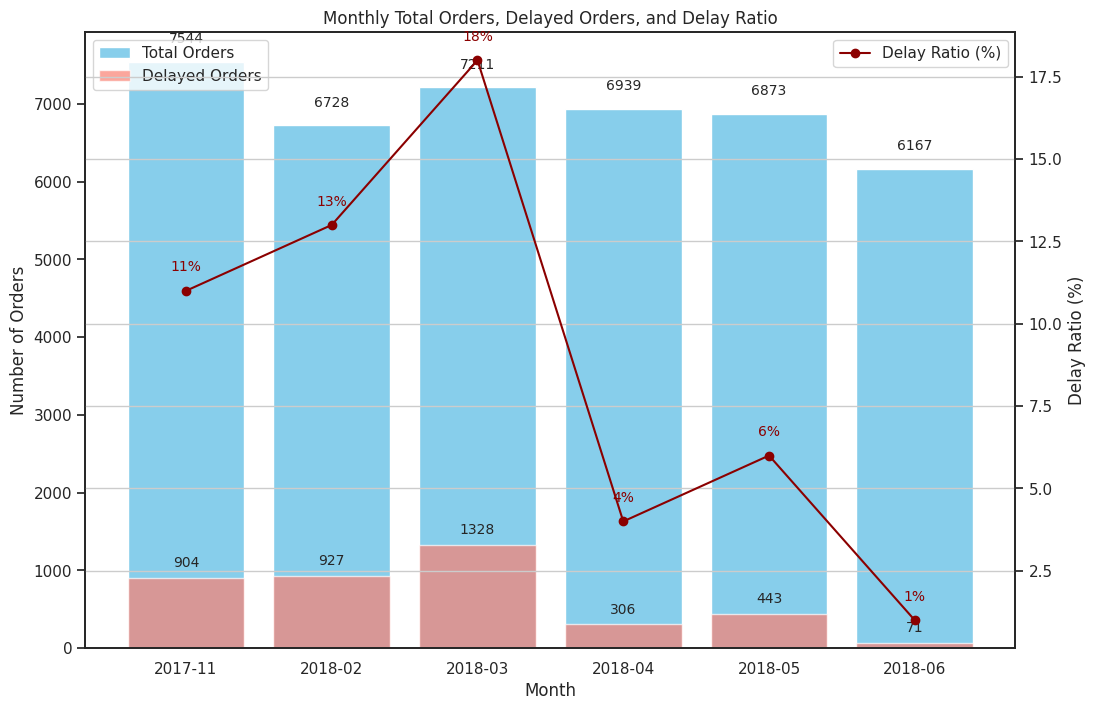

In [74]:

key_months = ['2017-11', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06']
orders_df['order_purchase_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')
key_orders = orders_df[orders_df['order_purchase_month'].astype(str).isin(key_months)]

# 전체 주문 건수 계산
total_orders_per_month = key_orders.groupby('order_purchase_month').size()

delayed_orders_per_month = key_orders[key_orders['is_delayed']].groupby('order_purchase_month').size()

delay_ratio_per_month = (delayed_orders_per_month / total_orders_per_month) * 100

result_df = pd.DataFrame({
    'Total Orders': total_orders_per_month,
    'Delayed Orders': delayed_orders_per_month,
    'Delay Ratio (%)': delay_ratio_per_month
}).fillna(0).astype(int)


fig, ax1 = plt.subplots(figsize=(12, 8))

#  전체 주문 수 및 지연된 주문 수
ax1.bar(result_df.index.astype(str), result_df['Total Orders'], color='skyblue', label='Total Orders')
ax1.bar(result_df.index.astype(str), result_df['Delayed Orders'], color='salmon', label='Delayed Orders', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(result_df.index.astype(str), result_df['Delay Ratio (%)'], color='darkred', marker='o', label='Delay Ratio (%)')

ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Orders')
ax2.set_ylabel('Delay Ratio (%)')
ax1.set_title('Monthly Total Orders, Delayed Orders, and Delay Ratio')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

for i, value in enumerate(result_df['Total Orders']):
    ax1.text(i, value + 200, str(value), ha='center', va='bottom', fontsize=10)
for i, value in enumerate(result_df['Delayed Orders']):
    ax1.text(i, value + 100, str(value), ha='center', va='bottom', fontsize=10)
for i, value in enumerate(result_df['Delay Ratio (%)']):
    ax2.text(i, value + 0.5, f'{value}%', ha='center', va='bottom', fontsize=10, color='darkred')

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 해당 월들을 확인 결과, 11월부터 18년 3월까지 지연율은 계속 증가했으며, 4월에 들어 지연율이 4%대로 줄어들었다.
# 3월까지 지연되던 물건들이 4월 이월되어 줄어들었거나, 대대적으로 물류 시스템 해소 가능성
# 이후 18년 6월까지 지연율을 1%대까지 줄임

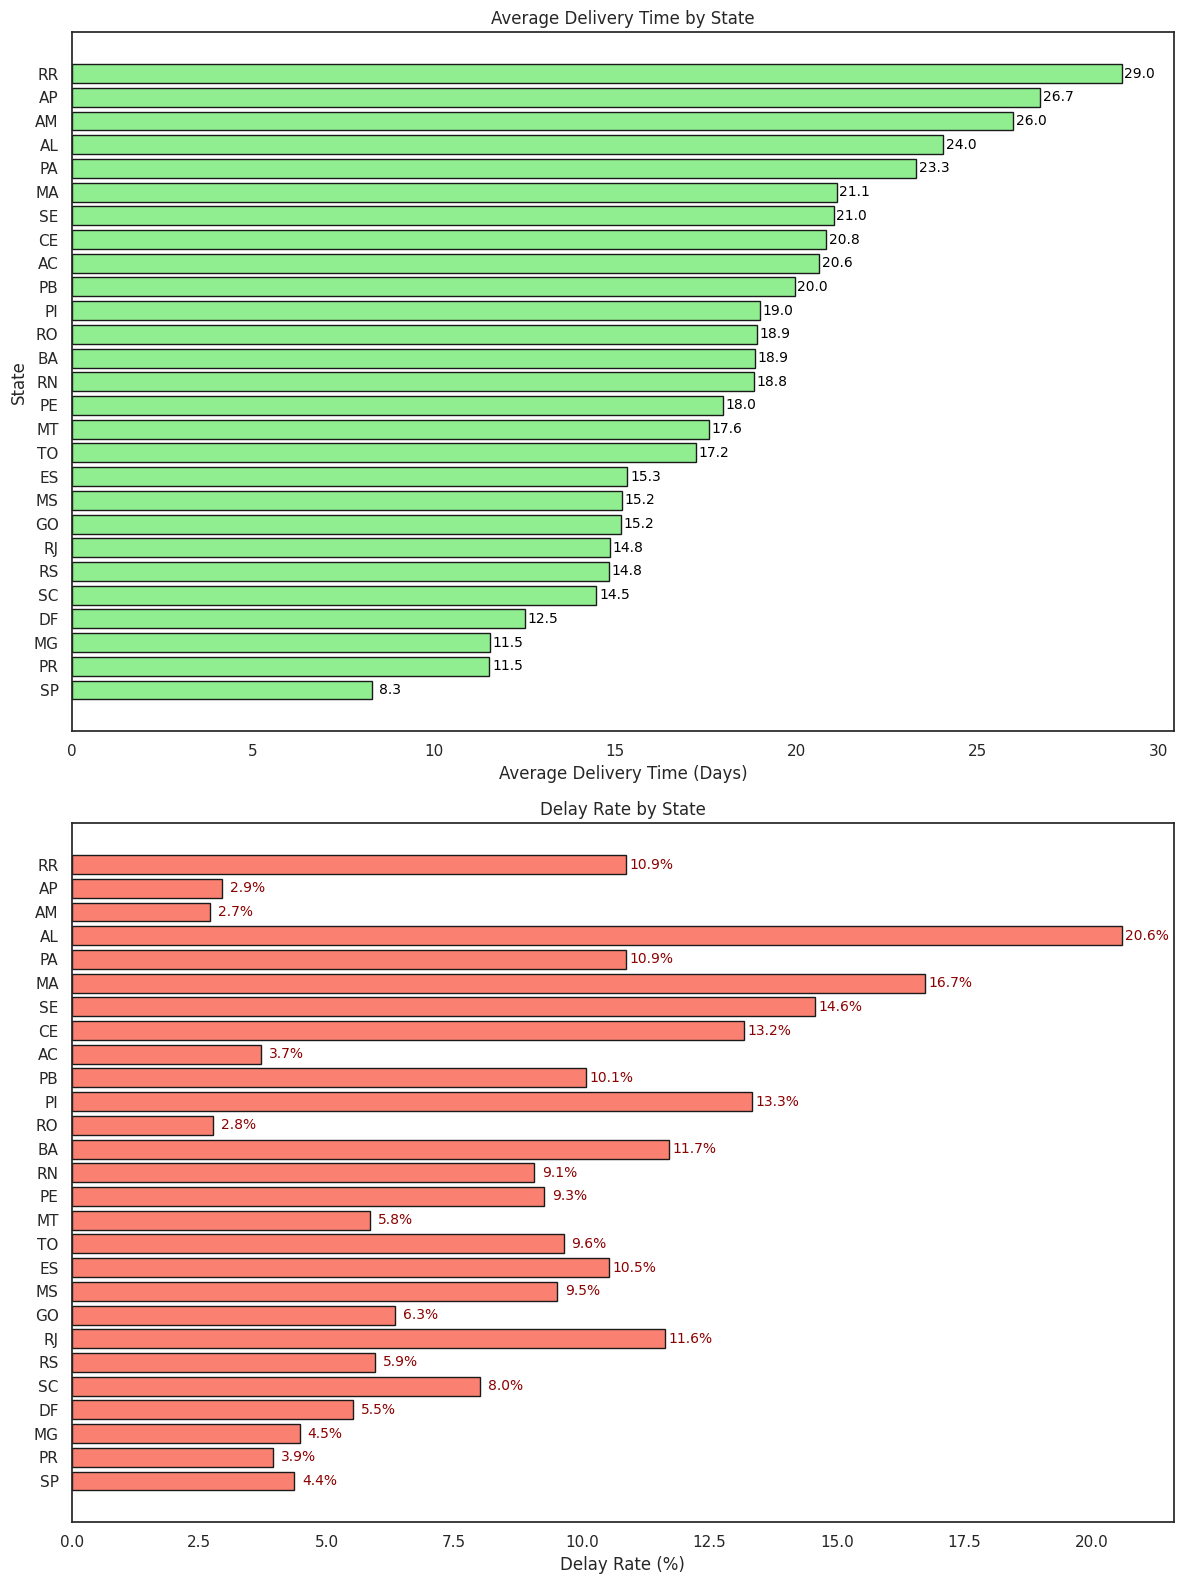

In [75]:
# 1.4 order_purchase_timestamp 부터 order_delivered_customer_date의 총 평균 배송시간을 customer_state 별로 시각화
# 1.5 customer_state 배송 지연율 시각화

merged_df = pd.merge(orders_df, customers, on='customer_id')

# 주문 구매 타임스탬프부터 고객 수령까지의 총 배송 시간 계산
merged_df['delivery_time'] = (merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']).dt.days

state_delivery_time = merged_df.groupby('customer_state')['delivery_time'].mean().sort_values()

state_delayed_orders = merged_df.groupby('customer_state')['is_delayed'].sum()
state_total_orders = merged_df.groupby('customer_state')['is_delayed'].count()


state_delay_rate = (state_delayed_orders / state_total_orders) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16), sharey=True)

ax1.barh(state_delivery_time.index, state_delivery_time, color='lightgreen', edgecolor='k')
ax1.set_xlabel('Average Delivery Time (Days)')
ax1.set_ylabel('State')
ax1.set_title('Average Delivery Time by State')
for i in ax1.patches:
    ax1.text(i.get_width() + 0.5, i.get_y() + i.get_height()/2, f'{i.get_width():.1f}', ha='center', va='center', fontsize=10, color='black')

ax2.barh(state_delay_rate.index, state_delay_rate, color='salmon', edgecolor='k')
ax2.set_xlabel('Delay Rate (%)')
ax2.set_title('Delay Rate by State')
for i in ax2.patches:
    ax2.text(i.get_width() + 0.5, i.get_y() + i.get_height()/2, f'{i.get_width():.1f}%', ha='center', va='center', fontsize=10, color='darkred')

plt.tight_layout()
plt.show()



In [76]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,delay,is_delayed,order_purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,-8.0,False,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,-6.0,False,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,-18.0,False,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,-13.0,False,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,-10.0,False,2018-02


In [77]:

orders_merged_df = pd.merge(order_items, orders_df, on='order_id')
orders_merged_df = pd.merge(orders_merged_df, order_reviews, on='order_id')
orders_merged_df = pd.merge(orders_merged_df, order_payments, on='order_id')
orders_merged_df=orders_merged_df.merge(products_trans,on='product_id')

numeric_columns = orders_merged_df.select_dtypes(['int64', 'float64']).columns
orders_merged_df = orders_merged_df[numeric_columns]

# 상관계수 계산
correlation_matrix = orders_merged_df.corr()

# 결과 출력
correlation_matrix

,order_item_id,price,freight_value,delay,review_score,payment_sequential,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
order_item_id,1.000000,-0.061018,-0.030336,-0.025920,-0.129344,-0.002406,0.074026,0.255814,-0.023230,-0.016512,-0.054721,-0.003330,0.007149,0.027779,-0.010115
price,-0.061018,1.000000,0.414014,-0.004194,-0.004515,0.006717,0.279000,0.741433,0.017853,0.201950,0.052378,0.340712,0.145386,0.225115,0.172667
freight_value,-0.030336,0.414014,1.000000,-0.041923,-0.037076,0.021956,0.185774,0.374270,0.022442,0.096853,0.021786,0.611302,0.309137,0.394332,0.324993
delay,-0.025920,-0.004194,-0.041923,1.000000,-0.228248,-0.002927,-0.039359,-0.019635,0.011005,0.006903,0.003852,0.008707,0.007213,-0.002196,-0.001987
review_score,-0.129344,-0.004515,-0.037076,-0.228248,1.000000,-0.004634,-0.042279,-0.082404,-0.006323,0.010354,0.022266,-0.028641,-0.020441,-0.026409,-0.010743
payment_sequential,-0.002406,0.006717,0.021956,-0.002927,-0.004634,1.000000,-0.086130,-0.064475,-0.005528,0.009945,-0.010705,0.044021,0.049023,0.024671,0.030868
payment_installments,0.074026,0.279000,0.185774,-0.039359,-0.042279,-0.086130,1.000000,0.274334,0.020717,0.036342,-0.000699,0.177936,0.117074,0.122614,0.138328
payment_value,0.255814,0.741433,0.374270,-0.019635,-0.082404,-0.064475,0.274334,1.000000,0.003298,0.156257,0.009833,0.305458,0.139966,0.216773,0.148374
product_name_lenght,-0.023230,0.017853,0.022442,0.011005,-0.006323,-0.005528,0.020717,0.003298,1.000000,0.089872,0.145183,0.021031,0.058800,-0.030353,0.062877
product_description_lenght,-0.016512,0.201950,0.096853,0.006903,0.010354,0.009945,0.036342,0.156257,0.089872,1.000000,0.117374,0.064236,0.007836,0.073896,-0.068087


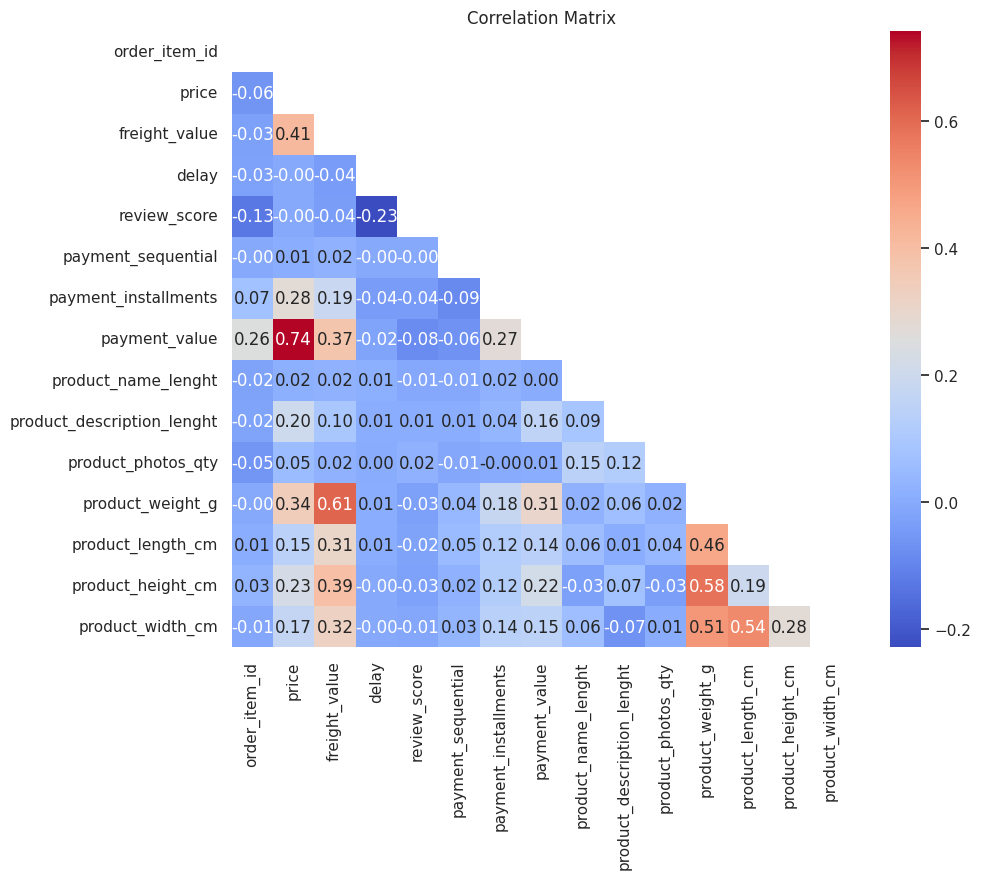

In [78]:
# 5.1 리뷰와 다른 수치형 컬럼 상관 관계 분석

np.mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', mask=np.mask)
plt.title('Correlation Matrix')
plt.show()

# 리뷰 점수와 각 주요 수치형 변수의 상관 관계를 파악한 결과, 크게 상관 관계를 가지지 않으며,
# delay, 즉 배송이 지연되었을 때 약한 음의 상관관계를 가지는 것이 확인됨

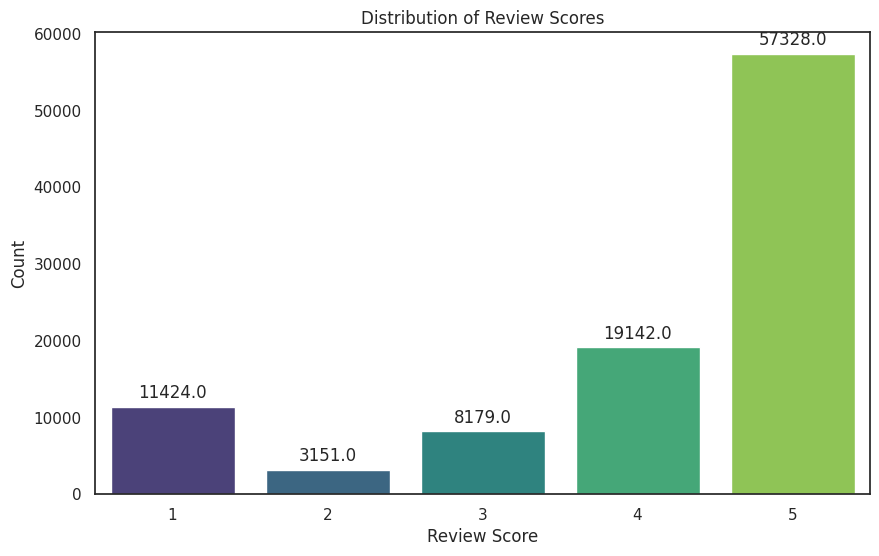

,proportion
review_score,
5,0.577763
4,0.192917
1,0.115133
3,0.082430
2,0.031756


In [79]:
# 5.2 review_score 분포 시각화
order_reviews2 = order_reviews.copy()
order_reviews2 = order_reviews2.merge(orders_df, on='order_id')
order_reviews2['review_score'] = order_reviews2['review_score'].astype(int)

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='review_score', data=order_reviews2, palette='viridis')


for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Review Score')
plt.ylabel('Count')
plt.title('Distribution of Review Scores')
plt.show()

order_reviews2['review_score'].value_counts(normalize=True)

# 4~5점의 비율이 약 77% 정도 차지, 고객 만족도가 높은 편
# 1~ 3점 리뷰를 받은 주문들의 특징 파악

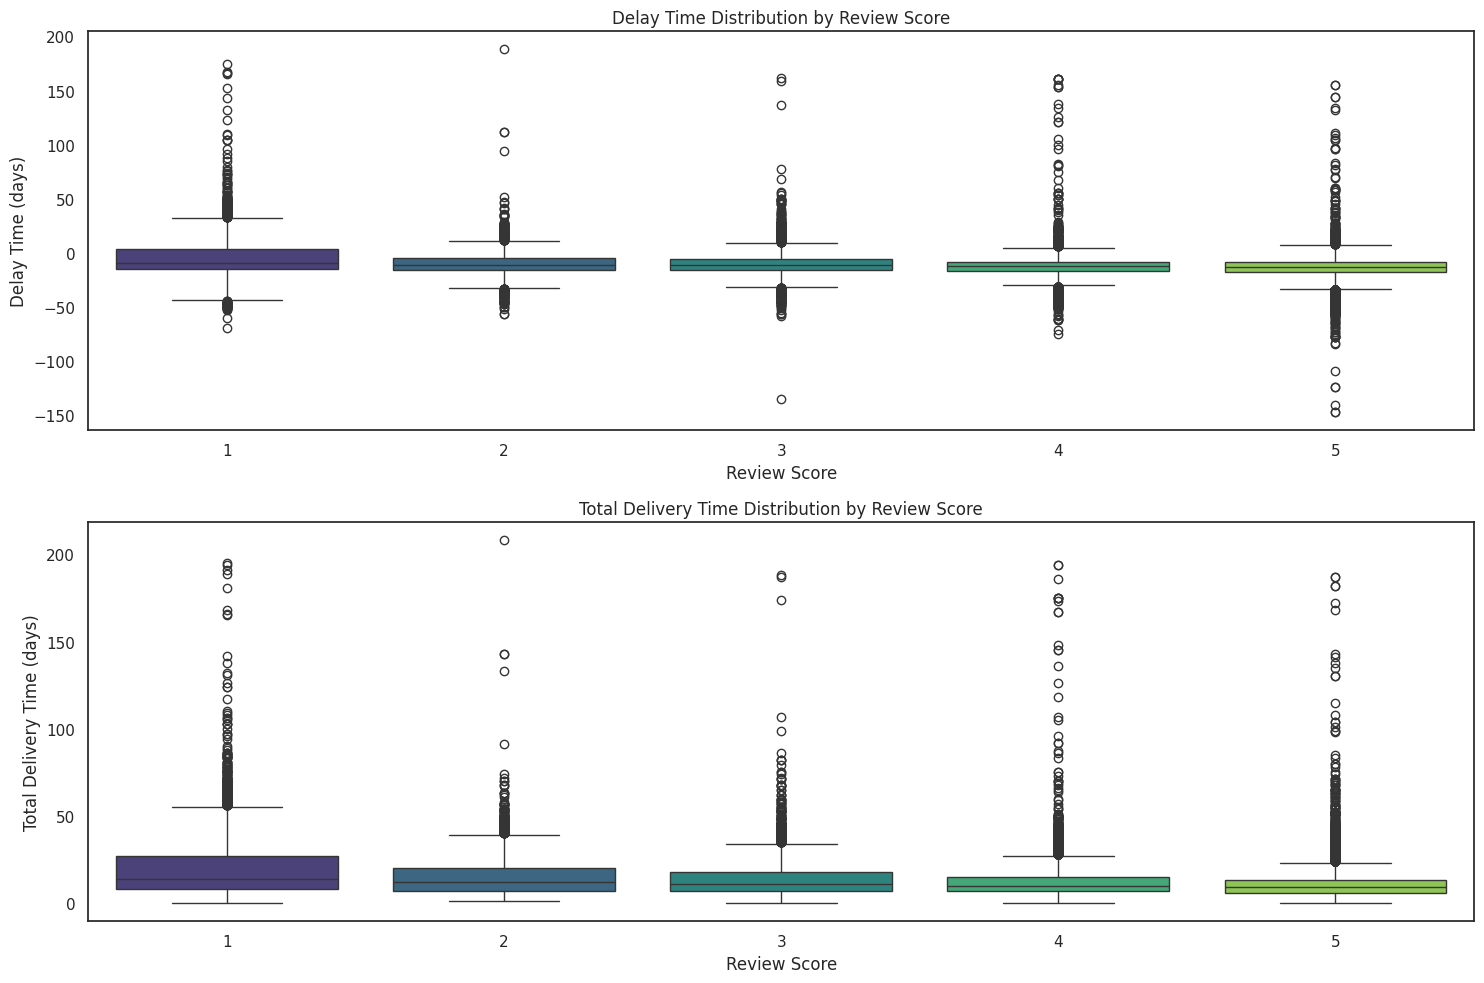

In [80]:
# 리뷰 점수별 지연

merged_df = pd.merge(order_items, orders_df, on='order_id')
merged_df = pd.merge(merged_df, order_reviews, on='order_id')
merged_df = pd.merge(merged_df, order_payments, on='order_id')

merged_df['delay_time'] = (merged_df['order_delivered_customer_date'] - merged_df['order_estimated_delivery_date']).dt.days

merged_df['total_delivery_time'] = (merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']).dt.days

plt.figure(figsize=(15, 10))


plt.subplot(2, 1, 1)
sns.boxplot(x='review_score', y='delay_time', data=merged_df, palette='viridis')
plt.title('Delay Time Distribution by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delay Time (days)')

plt.subplot(2, 1, 2)
sns.boxplot(x='review_score', y='total_delivery_time', data=merged_df, palette='viridis')
plt.title('Total Delivery Time Distribution by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Total Delivery Time (days)')

plt.tight_layout()
plt.show()

# 리뷰 점수가 1점인 경우 배송이 지연된 경우가 지연되지 않은 경우보다 훨씬 많으며
# 리뷰 점수가 5점인 경우 배송이 지연되지 않은 경우의 분포가 다른 점수대 보다 높다.
# 리뷰 점수가 작을 수록, 지연 시간이 더 긴 경향을 보인다.

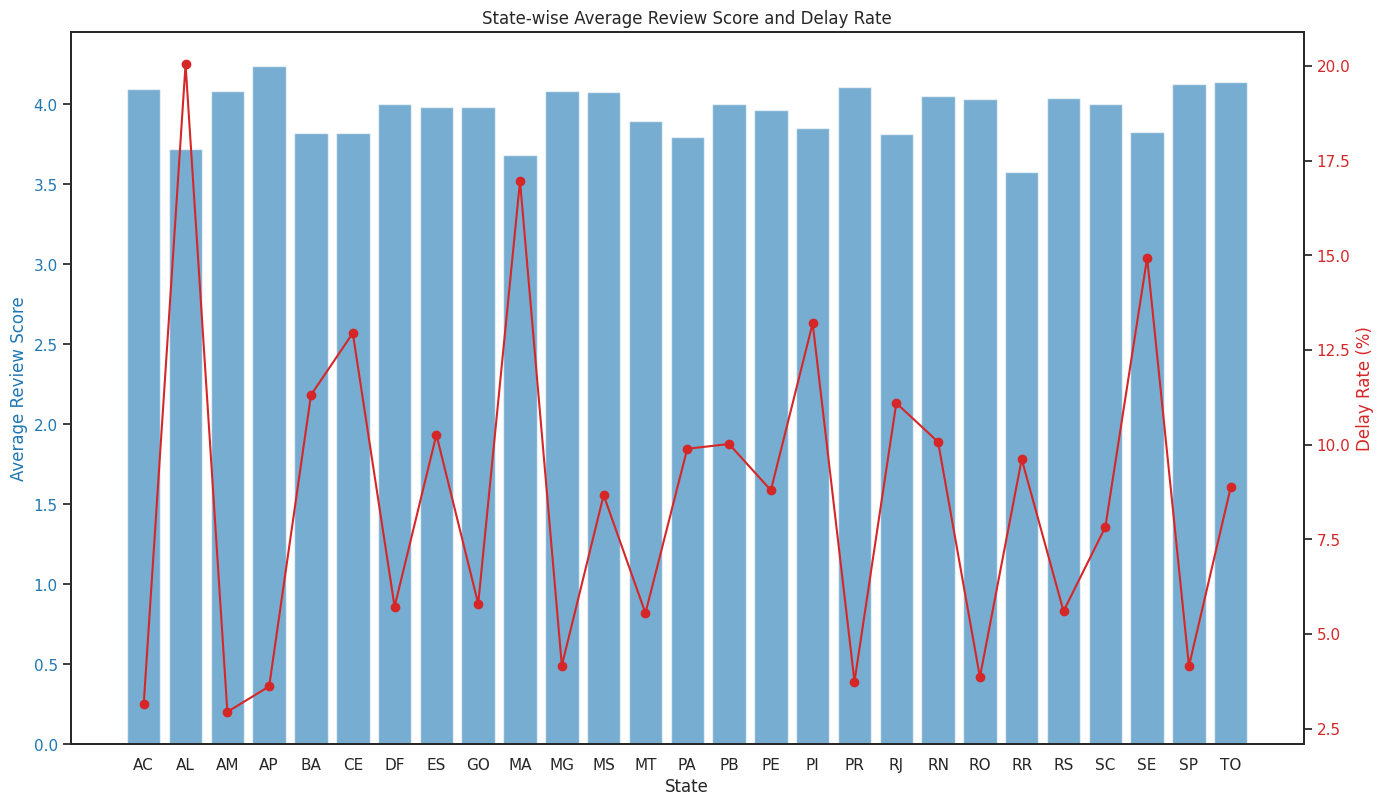

In [81]:
merged_df = pd.merge(merged_df, customers, on='customer_id')
state_avg_review = merged_df.groupby('customer_state')['review_score'].mean()


state_delayed_orders = merged_df.groupby('customer_state')['is_delayed'].sum()
state_total_orders = merged_df.groupby('customer_state')['is_delayed'].count()
state_delay_rate = (state_delayed_orders / state_total_orders) * 100

state_comparison_df = pd.DataFrame({
    'Average Review Score': state_avg_review,
    'Delay Rate (%)': state_delay_rate
}).dropna()


fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('State')
ax1.set_ylabel('Average Review Score', color=color)
ax1.bar(state_comparison_df.index, state_comparison_df['Average Review Score'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Delay Rate (%)', color=color)
ax2.plot(state_comparison_df.index, state_comparison_df['Delay Rate (%)'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('State-wise Average Review Score and Delay Rate')
plt.show()
# TOP3
# AP 북부에 위치한 주, 높은 리뷰 점수(4.24)와 낮은 지연률(4.24%)
# TO 북부에 위치하며, 높은 리뷰 점수(4.14)와 중간 정도의 지연률 (4.14%)
# SP: 남동부에 위치한 대도시, 높은 리뷰 점수 (4.13), 낮은 지연률(4.15%)

# BOT3
# RR, 북부에 위치한 주 리뷰 점수: 3.58, 지연률: 9.62%
# MA, 북동부에 위치한 주 리뷰 점수: 3.68, 지연률: 16.96%
# AL, 북동부에 위치한 주 리뷰 점수: 3.72, 지연률: 20.04%

# 평점 높은 주들은 물류 시스템이 비교적 잘 운영되고 있으며,
# 평점 낮은 주들은 물류 인프라 개선과 고객 서비스 향상이 필요하다고 판단됨

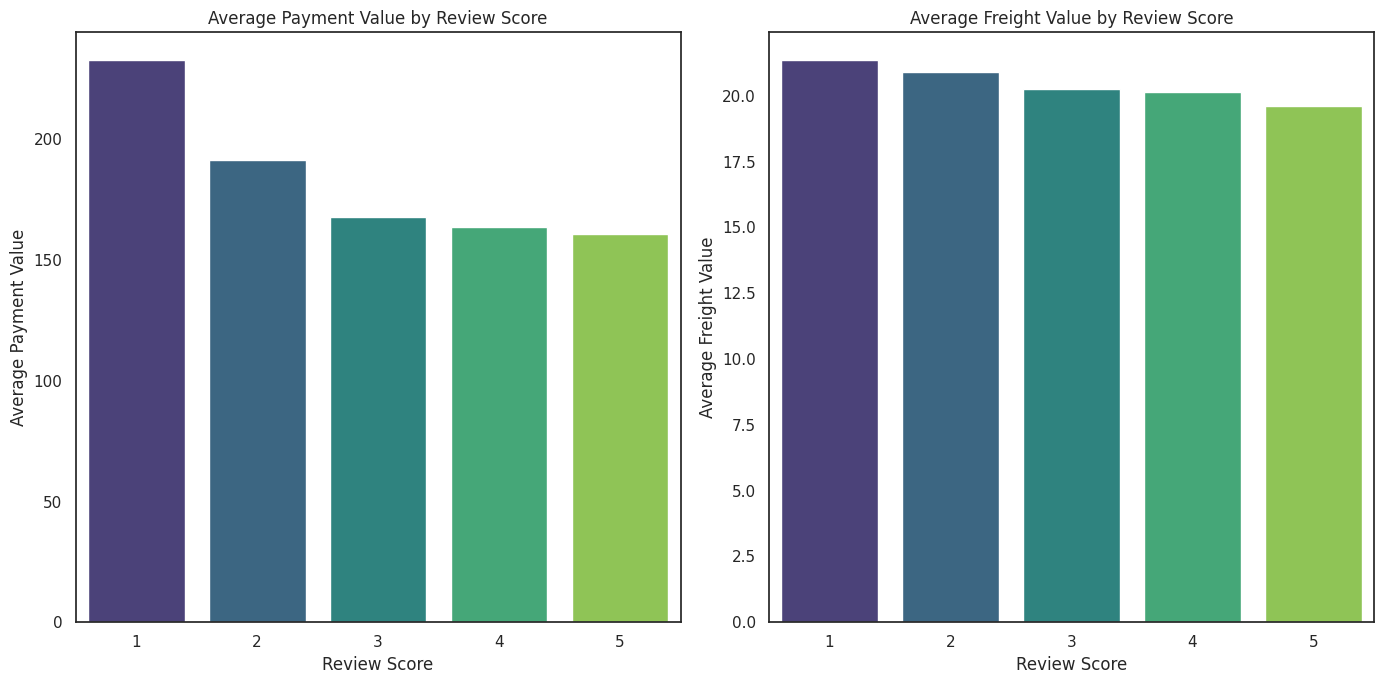

In [82]:
# 리뷰 점수별 평균 payment_value, freight_value 계산
avg_values = merged_df.groupby('review_score')[['payment_value', 'freight_value']].mean().reset_index()

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.barplot(x='review_score', y='payment_value', data=avg_values, palette='viridis')
plt.title('Average Payment Value by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Average Payment Value')

plt.subplot(1, 2, 2)
sns.barplot(x='review_score', y='freight_value', data=avg_values, palette='viridis')
plt.title('Average Freight Value by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Average Freight Value')

plt.tight_layout()
plt.show()

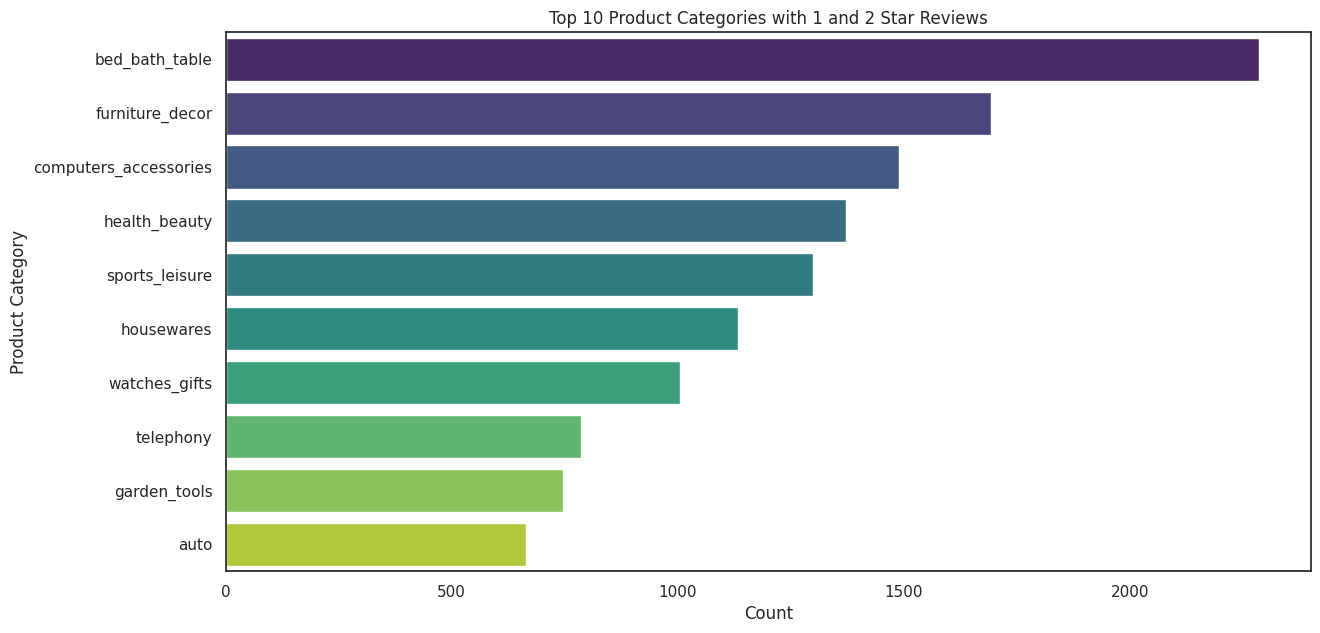

In [83]:
merged_df = pd.merge(merged_df, products_trans, on='product_id')

# 1점과 2점 리뷰의 제품 카테고리 선택
low_reviews = merged_df[merged_df['review_score'].isin([1, 2])]

# 제품 카테고리 분포 시각화 (상위 10개)
plt.figure(figsize=(14, 7))
sns.countplot(y='product_category_name', data=low_reviews, palette='viridis', order=low_reviews['product_category_name'].value_counts().head(10).index)
plt.title('Top 10 Product Categories with 1 and 2 Star Reviews')
plt.xlabel('Count')
plt.ylabel('Product Category')
plt.show()